In [1]:
#import useful libraries for analysis and modeling
import pandas as pd
import numpy as np
from sklearn import tree
from scipy import stats
import os
import pickle
import sys
import tempfile
import math
# import matplotlib as mpl
# import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.tree import export_graphviz, DecisionTreeClassifier
pd.options.mode.chained_assignment = None
from IPython.display import display, HTML
import warnings
import json
from matplotlib import cm  # color map
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import shap
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import scale
from sklearn.datasets import load_iris, load_wine
from matplotlib import pyplot as plt
import colorcet as cc

# Filter all warnings
warnings.filterwarnings("ignore")


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
classes = ['normal', 'scanning', 'ddos', 'injection', 'password', 'xss',
       'dos', 'mitm', 'ransomware', 'backdoor']

classes_df = pd.DataFrame(classes, columns=['class'])

# list of all extracted features
feats_all = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","ip.hdr_len","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Mean","Packet Length Total","UDP Len Min","UDP Len Max",\
                "Flow IAT Min","Flow IAT Max","Flow IAT Mean","Flow Duration",\
                    "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

# list of easy to compute online features - without means
feats_easy = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "Flow IAT Min","Flow IAT Max","Flow Duration","SYN Flag Count","ACK Flag Count",\
                    "PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

feats_no_time = ["ip.len","ip.ttl","tcp.flags.syn","tcp.flags.ack","tcp.flags.push","tcp.flags.fin","tcp.flags.rst",\
            "tcp.flags.ece","ip.proto","srcport","dstport","tcp.window_size_value","tcp.hdr_len","udp.length",\
            "Min Packet Length","Max Packet Length","Packet Length Total",\
                "SYN Flag Count","ACK Flag Count","PSH Flag Count","FIN Flag Count","RST Flag Count","ECE Flag Count"]

In [3]:
""" Function to save trained model to pickle"""
def save_model(RF, filename):
    pickle.dump(RF, open(filename, 'wb'))

def get_test_labels(IoT_Test):
    array_of_indices = []
    unique_labels = IoT_Test["Label"].unique()
    for lab in unique_labels:
        index = classes_df[classes_df['class'] == lab].index.values[0]
        array_of_indices.append(index)
    return unique_labels, array_of_indices

"""
Function to Fit model based on optimal values of depth and number of estimators and use it
to compute feature importance for all the features.
"""
def get_feature_importance(depth, n_tree, max_leaf, X_train, y_train, weight_of_samples,columns):
    
    # rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
    rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
    feature_importance = pd.DataFrame(rf_opt.feature_importances_)
    # feature_importance.index = X_train.columns
    feature_importance.index = columns
    feature_importance = feature_importance.sort_values(by=list(feature_importance.columns),axis=0,ascending=False)
    
    return feature_importance

"""
Function to Fit model based on optimal values of depth and number of estimators and feature importance
to find the fewest possible features to exceed the previously attained score with all selected features
"""
def get_fewest_features(depth, n_tree, max_leaf, importance):    
    sorted_feature_names = importance.index
    # print('sorted_feature_names: ', sorted_feature_names)
    features = []
    for f in range(1,len(sorted_feature_names)+1):
        features.append(sorted_feature_names[0:f])
    return features

def get_result_scores(classes, cl_report):
    precision=[]
    recall=[]
    f1_score=[]
    supports=[]
    for a_class in classes:
        precision.append(cl_report[a_class]['precision'])
        recall.append(cl_report[a_class]['recall'])
        f1_score.append(cl_report[a_class]['f1-score'])
        supports.append(cl_report[a_class]['support'])
    return precision, recall, f1_score, supports


def get_scores(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    # model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, max_leaf_nodes=max_leaf, n_jobs=10,
    #                                 random_state=42, bootstrap=False)
    
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    print(model)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)
    y_pred = model.predict(X_test[feats])

    y_test = [int(label) for label in y_test.values]
    y_pred = [int(label) for label in y_pred]

    class_report = classification_report(y_test, y_pred, labels=unique_labels, target_names=array_of_indices, output_dict = True)

    macro_score = class_report['macro avg']['f1-score']
    weighted_score = class_report['weighted avg']['f1-score']

    return model, class_report, macro_score, weighted_score, y_pred

def get_model(classes, depth, n_tree, feats, max_leaf, X_train, y_train, X_test, y_test, unique_labels,array_of_indices,weight_of_samples):
    model = RandomForestClassifier(max_depth=depth, n_estimators = n_tree, n_jobs=10,
                                    random_state=42, bootstrap=False)
    
    model.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

    return model

def get_x_y_flow(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def get_x_y_flow_binary(Dataset, feats):    
    X = Dataset[feats]
    y = Dataset['Label_Binary'].replace(classes, range(len(classes)))
    sample_nature = Dataset['sample_nature']
    return X, y, sample_nature

def expand_rows_and_get_scores(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs, unique_labels, array_of_indices):
    expanded_y_true = []
    expanded_y_pred = []
    #
    expanded_weights = []
    expanded_flow_IDs = []
    
    for true_label, pred_label, nature, mult, pkt_cnt, f_id in zip(y_true, y_pred, sample_nature, multiply, test_flow_pkt_cnt, test_flow_IDs):
        if nature == 'flw':
            expanded_y_true.extend([true_label] * (mult+1))
            expanded_y_pred.extend([pred_label] * (mult+1))
            #
            expanded_weights.extend([1/pkt_cnt] * (mult+1))
            expanded_flow_IDs.extend([f_id]* (mult+1))
        else:
            expanded_y_true.append(true_label)
            expanded_y_pred.append(pred_label)
            #
            expanded_weights.append(1/pkt_cnt)
            expanded_flow_IDs.append(f_id)
    
    # report = classification_report(expanded_y_true, expanded_y_pred)
    
    num_samples = len(expanded_y_true)

    expanded_y_true = [int(label) for label in expanded_y_true]
    expanded_y_pred = [int(label) for label in expanded_y_pred]
    # labels=array_of_indices, target_names=unique_labels,
    cl_report_PL = classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)
    macro_f1_PL = cl_report_PL['macro avg']['f1-score']
    weighted_f1_PL = cl_report_PL['weighted avg']['f1-score']
    try:
        micro_f1_PL = cl_report_PL['micro avg']['f1-score']
    except:
        micro_f1_PL = cl_report_PL['accuracy']
    ####
    
    c_report_FL =  classification_report(expanded_y_true, expanded_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True,sample_weight=expanded_weights)
    
    macro_f1_FL = c_report_FL['macro avg']['f1-score']
    weighted_f1_FL = c_report_FL['weighted avg']['f1-score']
    try:
        micro_f1_FL = c_report_FL['micro avg']['f1-score']
    except:
        micro_f1_FL = c_report_FL['accuracy']
    
    return num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, c_report_FL

def compute_flow_pkt_scores(y_pred, y_test, sample_nature,unique_labels,array_of_indices):

    # Create a data frame with the three columns
    df = pd.DataFrame({'y_pred': y_pred, 'y_test': y_test, 'sample_nature': sample_nature})
    
    # Split the data frame into two data frames based on sample_nature
    pkt_df = df[df['sample_nature'] == 'pkt']
    flw_df = df[df['sample_nature'] == 'flw']
    
    # Compute macro and weighted F1 scores for pkt_df
    pkt_df_y_true = [int(label) for label in pkt_df['y_test'].values]
    pkt_df_y_pred = [int(label) for label in pkt_df['y_pred']]

    # labels=array_of_indices, target_names=unique_labels,
    pkt_macro_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    pkt_weighted_f1 = classification_report(pkt_df_y_true, pkt_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']
    
    # Compute macro and weighted F1 scores for flw_df
    flw_df_y_true = [int(label) for label in flw_df['y_test'].values]
    flw_df_y_pred = [int(label) for label in flw_df['y_pred']]

    flw_macro_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['macro avg']['f1-score']
    flw_weighted_f1 = classification_report(flw_df_y_true, flw_df_y_pred, labels=unique_labels, target_names=array_of_indices, output_dict=True)['weighted avg']['f1-score']

    return pkt_macro_f1, pkt_weighted_f1, flw_macro_f1, flw_weighted_f1

In [4]:
# Define a function to check the conditions and assign values
def assign_sample_nature(row):
    if (row["Min Packet Length"] == -1 and
        row["Max Packet Length"] == -1 and
        row["Flow IAT Min"] == -1 and
        row["Flow IAT Max"] == -1):
        return "pkt"
    else:
        return "flw"

In [5]:
threshold_score = 0.99

In [6]:
def convert_str_to_dict(field_value):
    return json.loads(field_value.replace("\'", "\""))

def count_succ_classes(class_list):
    return len(class_list)

### Find the classes having a score > threshold in every model
def find_successful_classes(c_report):
    c_keys = c_report.keys()
    classes_succ = []
    for key in c_keys:
        if key not in ['accuracy', 'macro avg', 'micro avg', 'weighted avg']:
            if c_report[key]['f1-score'] > threshold_score:
                classes_succ.append(key)
    return classes_succ

### Get the score of 3 Classes
def get_score_of_classes(c_report):
    c_keys = c_report.keys()
    for key in c_keys:
        if key == class_name:
            return c_report[key]['f1-score']


In [7]:
def read_csv(csv_file_names):
    csv_files = []
    for f_name in csv_file_names:
        df = pd.read_csv(f_name, sep=';')
        csv_files.append(df)
        
    return pd.concat(csv_files)

In [8]:
def plot_line(x_axis_values, y_axis_values, labels, x_title, y_title, fig_title):
    
# solution_colors = {'Soter': '#6E7E99','Mousika': '#ffbb78', 'Planter': 'teal', 'pForest': '#8A9961', 
                    #    'NetBeacon': '#1f77b4', 'Flowrest': '#E06B5A', 'Jewel': '#A95C68'}
    fig = plt.figure(figsize = (15, 5))
    colors= {'#6E7E99', '#ffbb78','#8A9961','#1f77b4', '#E06B5A', '#A95C68'}
    # for x_axis_val, y_axis_val, label, color in zip(x_axis_values, y_axis_values, labels, colors):
    #     plt.plot(x_axis_val, y_axis_val, label=label, color=color, linewidth=1.5)
    
    for x_axis_val, y_axis_val, color in zip(x_axis_values, y_axis_values, colors):
        plt.plot(x_axis_val, y_axis_val, 'g*-', color=color, linewidth=1.5, markersize=4)
    plt.plot(x_axis_val, [0.7 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.plot(x_axis_val, [0.5 for i in range(0, len(x_axis_val))], color='gray', linestyle='--', lw=1)
    plt.xlabel(x_title, fontsize=15, labelpad=13)
    plt.ylabel(y_title, fontsize=15, labelpad=14)
    plt.xticks(rotation=90)
    plt.title(fig_title)
    plt.legend()
    plt.show()

In [9]:
def f_gini(v):
    p = v/v.sum()
    return np.multiply(p, 1-p).sum()



def f_entropy(v):
    return sps.entropy(pk=v)



def f_misclassification(v):
    p = v/v.sum()
    
def calcImportanceMatrix(rf_clf):
    """
    Calculates the importance matrix of predictors for each class.

    Arguments:
        rf_clf - The random forest classifier to calculate the importance matrix for.
        Must (?) be a RandomForestClassifier object. EXTENSIBLE TO ANY DECISION TREE CLASSIFIER FROM sklearn.tree?

    Returns:
        importance_matrix - The importance matrix with the importance of each predictor in predicting a class.
        A n by m numpy array.

    """

    # get the number of classes being predicted by the random forest
    classes = rf_clf.classes_
    n_classes = len(classes)

    # init storage for the predictor importances by classes by trees
    importance_matrix = []

    #dec_tree = rf_clf.estimators_[0]
    for dec_tree in rf_clf.estimators_:

        # get the criterion used to measure impurity
        criterion = dec_tree.get_params()['criterion']
        if criterion == 'gini':
            f_impurity = f_gini
        elif criterion == 'entropy':
            f_impurity = f_entropy
        elif criterion == 'misclassification':
            f_impurity = f_misclassification
        else:
            f_impurity = 0
            print('Unassigned impurity measure')

        # get the number of features and nodes in the tree
        feature = dec_tree.tree_.feature
        n_features = dec_tree.tree_.n_features
        n_nodes = dec_tree.tree_.__getstate__()['node_count']
        nodes = dec_tree.tree_.__getstate__()['nodes']
        parent_node_ind = -np.ones(shape=n_nodes, dtype='<i8')
        #parent_node_ind[0] = n_nodes + 1
        #print(parent_node_ind)
        for par_ind,node in enumerate(nodes):
            if node[0] != -1:
                parent_node_ind[node[0]] = par_ind
            if node[1] != -1:
                parent_node_ind[node[1]] = par_ind
        #print(parent_node_ind)

        # identify the leaves of the tree
        is_leaves = np.array([node[0]==-1 and node[1]==-1 for node in nodes])
        
        leaves_index = np.nonzero(is_leaves)[0]

        values_sorted = dec_tree.tree_.__getstate__()['values']
        #print ('nodes', nodes, len(nodes), len(values_sorted[:,0,:]))
        node_pred = np.argmax(values_sorted[:,0,:], axis=1)
        # print('NODE PRED:', node_pred)
        leaves_class_index = node_pred[is_leaves]
        # print('INDEX:', leaves_class_index)
        # print(leaves_class_index)
        # print(leaves_class_index)
        #for par_ind,node in enumerate(nodes):
        #    print(par_ind,parent_node_ind[par_ind],is_leaves[par_ind],node,
        #          values_sorted[par_ind], values_sorted[par_ind].sum())
        node_unvisited = np.ones((n_classes, n_nodes), dtype=bool)
        tree_importances = np.zeros((n_classes, n_features))
        for leaf_i,leaf_c_i in zip(leaves_index,leaves_class_index):
            current_i = parent_node_ind[leaf_i]
            # print('START from leaf ', leaf_i, 'with class ', leaf_c_i)
            #print('whose parent is ', current_i)
            # walk the tree and calculate the importance of the predictor
            while current_i != -1 and node_unvisited[leaf_c_i,current_i]:
                current_node = nodes[current_i]
                left_node = nodes[current_node['left_child']]
                right_node = nodes[current_node['right_child']]
                current_feature = current_node['feature']
                
                current_values = values_sorted[current_i,0,:]
                left_values = values_sorted[current_node['left_child'],0,:]
                right_values = values_sorted[current_node['right_child'],0,:]
                
                # print(leaves_class_index, current_values_class)
                current_values_class = np.array([
                    current_values[leaf_c_i],
                    current_values[np.arange(len(current_values)) != leaf_c_i].sum()
                ])
                left_values_class = np.array([
                    left_values[leaf_c_i],
                    left_values[np.arange(len(left_values)) != leaf_c_i].sum()
                ])
                right_values_class = np.array([
                    right_values[leaf_c_i],
                    right_values[np.arange(len(right_values)) != leaf_c_i].sum()
                ])
                #print(
                #    current_values,
                #    np.array([current_values[leaf_c_i],
                #              current_values[np.arange(len(current_values))!=leaf_c_i].sum()])
                #     )
                #print(current_values.sum(), left_values.sum(), right_values.sum(),
                #     left_values.sum()/current_values.sum(), right_values.sum()/current_values.sum(),
                #      current_node['weighted_n_node_samples'], left_node['weighted_n_node_samples'],
                #      right_node['weighted_n_node_samples']
                #     )
                tree_importances[leaf_c_i,current_feature] += (
                        current_node['weighted_n_node_samples'] * f_impurity(current_values_class) -
                        left_node['weighted_n_node_samples'] * f_impurity(left_values_class) -
                        right_node['weighted_n_node_samples'] * f_impurity(right_values_class)
                        )
                #print('\n', current_node, (
                #        current_node['weighted_n_node_samples'] * f_importance(current_values) -
                #        left_node['weighted_n_node_samples'] * f_importance(left_values) -
                #        right_node['weighted_n_node_samples'] * f_importance(right_values)
                #        ))
                ###
                node_unvisited[leaf_c_i,current_i] = False
                current_i = parent_node_ind[current_i]
                #print('next current is ', current_i)
        # print(tree_importances.shape)
        importance_matrix.append(tree_importances/nodes[0]['weighted_n_node_samples'])
        # print(importance_matrix)

    # average the predictor importances for each class by all of the trees in the forest
    importance_matrix = np.mean(importance_matrix, axis = 0)
    #normalise importance over each class
    importance_matrix = (importance_matrix.T / np.sum(importance_matrix, axis=1)).T
    return(importance_matrix)

## WITHOUT LIMITATION

#### N=3

In [10]:
file_names_N3 = ['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D5-15_T1-20.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D5-19_T21-40.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D15-22_T1-20.csv', 
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D20-30_T21-40.csv',
                 '/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/no_limit_solutions/unsw_models_3pkts_D22-30_T1-20.csv']

In [11]:
model_analysis_noLimit_N3 = read_csv(file_names_N3)

In [12]:
threshold_score = 0.99
model_analysis_noLimit_N3['c_report_FL_99'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_99'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_99'] = model_analysis_noLimit_N3['succ_classes_FL_99'].apply(count_succ_classes)
#
threshold_score = 0.97
model_analysis_noLimit_N3['c_report_FL_97'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_97'] = model_analysis_noLimit_N3['c_report_FL_97'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_97'] = model_analysis_noLimit_N3['succ_classes_FL_97'].apply(count_succ_classes)
#
threshold_score = 0.95
model_analysis_noLimit_N3['c_report_FL_95'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_95'] = model_analysis_noLimit_N3['c_report_FL_95'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_95'] = model_analysis_noLimit_N3['succ_classes_FL_95'].apply(count_succ_classes)
#
threshold_score = 0.93
model_analysis_noLimit_N3['c_report_FL_93'] = model_analysis_noLimit_N3['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_noLimit_N3['succ_classes_FL_93'] = model_analysis_noLimit_N3['c_report_FL_93'].apply(find_successful_classes)
model_analysis_noLimit_N3['COUNT_succ_classes_FL_93'] = model_analysis_noLimit_N3['succ_classes_FL_93'].apply(count_succ_classes)
###
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_noLimit_N3['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_noLimit_N3['score_Netatmo_Weather_station'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_noLimit_N3['score_Smart_Things'] = model_analysis_noLimit_N3['c_report_FL_99'].apply(get_score_of_classes)

In [13]:
model_analysis_3CLasses = model_analysis_noLimit_N3[model_analysis_noLimit_N3['COUNT_succ_classes_FL_99']>2]

In [14]:
# model_analysis_3CLasses.sort_values(by='no_feats').head(15)[['depth','tree','no_feats','feats','score_Light_Bulbs_LiFX_Smart_Bulb','score_Netatmo_Weather_station','score_Smart_Things','Macro_f1_FL','Weighted_f1_FL','Micro_f1_FL']]

#### The scores more than 80%

In [21]:
model_analysis_noLimit_N2 = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/model_analysis_results/limited_models/ToN-IoT_Limited_2pkts_noTime.csv', sep=';')

In [22]:
model_analysis_noLimit_N2.sort_values(by='Macro_f1_FL', ascending=False).head(15)

depth  tree  no_feats  \
384                                            [21, 19]     2        17   
177                                                [32]     1        17   
2332               [21, 22, 19, 20, 20, 21, 18, 19, 17]     9        10   
269                                                [34]     1        17   
1780                       [25, 19, 16, 19, 22, 19, 17]     7        10   
200                                                [34]     1        17   
2700           [22, 26, 29, 24, 23, 21, 23, 25, 25, 24]    10        10   
246                                                [34]     1        17   
2677           [22, 25, 29, 24, 20, 19, 22, 25, 25, 24]    10        10   
2654           [22, 21, 26, 22, 19, 19, 22, 24, 24, 22]    10        10   
2746           [25, 28, 29, 31, 23, 21, 23, 26, 25, 29]    10        10   
223                                                [34]     1        17   
2723           [25, 27, 29, 25, 23, 21, 23, 25, 25, 29]    10        10   
2608           [19, 18, 19, 20, 18, 16, 19, 20, 20, 21]    10        10   
3560  [30, 29, 30, 31, 25, 32, 30, 31, 33, 31, 28, 2...    13        19   

      N_Leaves  Macro_f1_FL  Weighted_f1_FL  Micro_f1_FL  \
384        217     0.431131        0.406551     0.445310   
177        349     0.418777        0.400220     0.441403   
2332       261     0.416642        0.370376     0.428448   
269        500     0.416334        0.398879     0.431371   
1780       261     0.416228        0.368117     0.430928   
200        393     0.416188        0.398119     0.432128   
2700       437     0.416059        0.372791     0.427425   
246        481     0.416051        0.398012     0.430886   
2677       393     0.415961        0.371785     0.426969   
2654       349     0.415912        0.371322     0.426946   
2746       500     0.415890        0.372041     0.426934   
223        437     0.415886        0.397715     0.430459   
2723       481     0.415801        0.372047     0.426868   
2608       261     0.415771        0.370728     0.427903   
3560       481     0.414794        0.394905     0.428311   

                                                  feats  pkt_macro_f1  \
384   ['dstport', 'ip.ttl', 'Min Packet Length', 'ip...      0.209371   
177   ['dstport', 'ip.ttl', 'ip.len', 'Min Packet Le...      0.211740   
2332  ['dstport', 'ip.ttl', 'Min Packet Length', 'ip...      0.265991   
269   ['dstport', 'ip.ttl', 'ip.len', 'Min Packet Le...      0.213086   
1780  ['dstport', 'ip.ttl', 'Min Packet Length', 'Ma...      0.246535   
200   ['dstport', 'ip.ttl', 'ip.len', 'Min Packet Le...      0.211802   
2700  ['dstport', 'ip.ttl', 'Max Packet Length', 'Mi...      0.243474   
246   ['dstport', 'ip.ttl', 'ip.len', 'Min Packet Le...      0.213086   
2677  ['dstport', 'ip.ttl', 'Max Packet Length', 'Mi...      0.244078   
2654  ['dstport', 'ip.ttl', 'Max Packet Length', 'Mi...      0.242941   
2746  ['dstport', 'ip.ttl', 'Max Packet Length', 'Mi...      0.266868   
223   ['dstport', 'ip.ttl', 'ip.len', 'Min Packet Le...      0.211873   
2723  ['dstport', 'ip.ttl', 'Max Packet Length', 'Mi...      0.243559   
2608  ['dstport', 'ip.ttl', 'Max Packet Length', 'Mi...      0.243195   
3560  ['dstport', 'ip.len', 'ip.ttl', 'Max Packet Le...      0.212242   

      pkt_weighted_f1  flw_macro_f1  flw_weighted_f1  F1_macro  F1_weighted  \
384          0.296062      0.468607         0.428674  0.346402     0.362669   
177          0.299260      0.449813         0.418530  0.341531     0.361788   
2332         0.312653      0.455883         0.389321  0.364568     0.348711   
269          0.302218      0.446592         0.415521  0.341116     0.362673   
1780         0.336063      0.454250         0.384270  0.361676     0.359409   
200          0.299290      0.446680         0.415312  0.340568     0.361227   
2700         0.287367      0.454627         0.392944  0.351129     0.338118   
246          0.302218      0.446298         0.414565  0.340926     0.362096   
2677    

In [23]:
model_analysis_noLimit_N3 = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/model_analysis_results/limited_models/ToN-IoT_Limited_3pkts_noTime.csv', sep=';')

In [28]:
model_analysis_noLimit_N3[model_analysis_noLimit_N3['tree']<4].sort_values(by='Macro_f1_FL', ascending=False).head(40)

depth  tree  no_feats  N_Leaves  Macro_f1_FL  Weighted_f1_FL  \
723  [21, 20, 19]     3        11       349     0.520204        0.703649   
700  [19, 19, 18]     3        11       305     0.518710        0.702489   
677  [18, 17, 18]     3        11       261     0.517673        0.702239   
800  [25, 23, 26]     3        19       481     0.510216        0.702384   
796  [24, 22, 21]     3        15       481     0.510021        0.699088   
819  [25, 23, 22]     3        15       500     0.509991        0.698756   
823  [25, 23, 26]     3        19       500     0.509748        0.702104   
791  [22, 22, 22]     3        10       481     0.500815        0.680204   
814  [22, 23, 22]     3        10       500     0.500771        0.684791   
431      [22, 26]     2        18       305     0.496602        0.704303   
220          [19]     1        14       437     0.495262        0.704028   
454      [25, 26]     2        18       349     0.493442        0.699052   
754  [24, 23, 26]     3        19       393     0.491739        0.694862   
732  [26, 25, 21]     3        20       349     0.491497        0.695553   
197          [19]     1        14       393     0.491407        0.696130   
174          [19]     1        14       349     0.491172        0.695798   
633  [18, 20, 18]     3        13       173     0.490904        0.706798   
821  [23, 25, 23]     3        17       500     0.490853        0.662886   
542      [23, 23]     2        14       500     0.490528        0.679915   
724  [22, 22, 21]     3        12       349     0.490424        0.601689   
497      [24, 25]     2        15       437     0.490292        0.694245   
199          [27]     1        16       393     0.489667        0.704651   
474      [24, 25]     2        15       393     0.489548        0.692344   
475      [25, 23]     2        16       393     0.489529        0.689068   
476      [29, 22]     2        17       393     0.489154        0.700447   
543      [24, 25]     2        15       500     0.489024        0.691056   
520      [24, 25]     2        15       481     0.488963        0.691066   
85           [16]     1        17       173     0.488560        0.699100   
498      [25, 23]     2        16       437     0.488428        0.688203   
777  [25, 23, 26]     3        19       437     0.488121        0.699082   
229          [23]     1        23       437     0.487933        0.696808   
261          [21]     1         9       500     0.487690        0.605724   
773  [24, 22, 21]     3        15       437     0.487598        0.691817   
496      [20, 20]     2        14       437     0.487572        0.674378   
238          [21]     1         9       481     0.487391        0.604976   
473      [19, 20]     2        14       393     0.486346        0.671531   
545      [29, 24]     2        17       500     0.485399        0.701328   
522      [29, 24]     2        17       481     0.485140        0.700858   
521      [28, 23]     2        16       481     0.484553        0.687562   
544      [28, 28]     2        16       500     0.484204        0.686747   

     Micro_f1_FL                                              feats  \
723     0.683096  ['dstport', 'ip.len', 'ip.ttl', 'Max Packet Le...   
700     0.681771  ['dstport', 'ip.len', 'ip.ttl', 'Max Packet Le...   
677     0.681476  ['dstport', 'ip.len', 'ip.ttl', 'Max Packet Le...   
800     0.678945  ['dstport', 'ip.len', 'Max Packet Length', 'ip...   
796     0.675329  ['dstport', 'ip.len', 'Max Packet Length', 'ip...   
819     0.674755  ['dstport', 'ip.len', 'Max Packet Length', 'ip...   
823     0.678767  ['dstport', 'ip.len', 'Max Packet Length', 'ip...   
791     0.653711  ['dstport', 'ip.len', 'Max Packet Length', 'ip...   
814     0.657599  ['dstport', 'ip.len', 'Max Packet Length', 'ip...   
431     0.682707  ['dstport', 'ip.len', 'Max Packet Length', 'Pa...   
220     0.685628  ['ip.len', 'dstport', 'Packet Length Total', '...   
454     0.679209  ['dstport', 'ip.len', 'Ma

In [19]:
model_analysis_noLimit_N4_2 = pd.read_csv('/home/nds-admin/distributed_in_band/ToN-IoT/model_analysis_results/ToN-IoT_unLimited_4pkts_noTime_D5-30_T1-40.csv', sep=';')

In [20]:
model_analysis_noLimit_N4_2.sort_values(by='Macro_f1_FL', ascending=False)

depth  tree  no_feats  Macro_f1_FL  Weighted_f1_FL  Micro_f1_FL  \
5103      18     9        21     0.614202        0.694240     0.681926   
4504      18     8        20     0.599204        0.691287     0.680037   
20026     17    34        17     0.598603        0.691457     0.673593   
18830     17    32        17     0.598361        0.691335     0.673242   
4481      17     8        20     0.598083        0.693980     0.680536   
...      ...   ...       ...          ...             ...          ...   
18         5     1        19     0.153436        0.323057     0.306539   
12         5     1        13     0.145484        0.217703     0.319385   
21         5     1        22     0.145175        0.283848     0.277489   
4          5     1         5     0.137579        0.260236     0.258684   
0          5     1         1     0.100840        0.104001     0.135489   

                                                   feats  pkt_macro_f1  \
5103   ['dstport', 'ip.len', 'Max Packet Length', 'ip...      0.399374   
4504   ['dstport', 'ip.len', 'Max Packet Length', 'ip...      0.369752   
20026  ['dstport', 'ip.len', 'Packet Length Total', '...      0.359468   
18830  ['dstport', 'ip.len', 'Packet Length Total', '...      0.360796   
4481   ['dstport', 'ip.len', 'Packet Length Total', '...      0.345119   
...                                                  ...           ...   
18     ['Min Packet Length', 'ip.len', 'ip.proto', 'P...      0.072767   
12     ['Min Packet Length', 'ip.len', 'ip.proto', 'P...      0.134722   
21     ['Min Packet Length', 'ip.len', 'ip.proto', 'P...      0.096427   
4      ['Min Packet Length', 'ip.len', 'ip.proto', 'P...      0.054927   
0                                  ['Min Packet Length']      0.005814   

       pkt_weighted_f1  flw_macro_f1  flw_weighted_f1  F1_macro  F1_weighted  \
5103          0.458635      0.706948         0.836523  0.483822     0.564641   
4504          0.455643      0.699857         0.831094  0.462853     0.561544   
20026         0.408020      0.701578         0.841700  0.465805     0.541883   
18830         0.409289      0.700545         0.841074  0.466129     0.542123   
4481          0.446823      0.689079         0.835552  0.444479     0.558095   
...                ...           ...              ...       ...          ...   
18            0.130755      0.217166         0.464433  0.111562     0.225506   
12            0.197208      0.160306         0.223437  0.140530     0.204628   
21            0.179605      0.171881         0.336484  0.127212     0.242556   
4             0.123610      0.183360         0.331586  0.100656     0.201653   
0             0.001741      0.131767         0.160120  0.051355     0.065411   

       num_samples  Macro_F1_PL  Weighted_F1_PL  Micro_F1_PL  \
5103       1576856     0.641058        0.886076     0.878816   
4504       1576856     0.629180        0.886005     0.879610   
20026      1576856     0.549187        0.883546     0.875421   
18830      1576856     0.548715        0.883501     0.875296   
4481       1576856     0.623669        0.884483     0.876500   
...            ...          ...             ...          ...   
18         1576856     0.134474        0.303620     0.380997   
12         1576856     0.089915        0.091509     0.114639   
21         1576856     0.104103        0.142109     0.120203   
4          1576856     0.102317        0.103144     0.106754   
0          1576856     0.122862        0.050997     0.058021   

                                            cl_report_FL  \
5103   {'xss': {'precision': 0.779587775536265, 'reca...   
4504   {'xss': {'precision': 0.7787606237627033, 'rec...   
20026  {'xss': {'precision': 0.843239134704554, 'reca...   
18830  {'xss': {'precision': 0.8453213875348394, 'rec...   
4481   {'xss': {'precision': 0.8009548390521689, 'rec...   
...                                                  ...   
18     {'xss': {'precision': 0.7176056707216926, 'rec...   
12     {'xss': {'pr

In [40]:
model_analysis_noLimit_N4.sort_values(by='Macro_f1_FL', ascending=False).head(1)['feats'].to_list()[0]

"['dstport', 'ip.len', 'Max Packet Length', 'ip.ttl', 'Packet Length Total', 'tcp.window_size_value', 'udp.length', 'tcp.hdr_len', 'Min Packet Length', 'srcport', 'PSH Flag Count', 'SYN Flag Count', 'ip.proto', 'ACK Flag Count', 'RST Flag Count', 'tcp.flags.push', 'FIN Flag Count', 'tcp.flags.ack', 'tcp.flags.rst', 'ECE Flag Count', 'tcp.flags.syn']"

In [15]:
model_analysis_N3_BEST = model_analysis_noLimit_N3[model_analysis_noLimit_N3['Weighted_f1_FL'] > 0.85].sort_values(by='Weighted_f1_FL', ascending=False).head(3000)

In [16]:
# Load Train and Test data
time = "normal"
npkts = 3
feats_to_use = feats_all
if(time=="normal"):
    train_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/train_data_"+str(npkts)+".csv")
    test_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/test/csv_files/16-10-05.pcap.txt_"+str(npkts)+"_pkts.csv")
#
flow_pkt_counts = pd.read_csv("/home/nds-admin/UNSW_PCAPS/hyb_code/16-10-05-flow-counts.csv")
#
### FIX ###
flow_count_dict = flow_pkt_counts.set_index("flow.id")["count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
test_data["pkt_count"] = test_data["Flow ID"].map(flow_count_dict)
###########

#### To get packet count of each flow in train data
packet_data = pd.read_csv("/home/nds-admin/UNSW_PCAPS/train/train_data_hybrid/UNSW_train_ALL_PKT_DATE.csv")
packet_data = packet_data[['Flow ID', 'packet_count', 'File']]
packet_data['File_ID'] = packet_data['Flow ID'] + ' ' + packet_data['File']
packet_data = packet_data.drop_duplicates(subset='File_ID', keep='first')
train_data['File_ID'] = train_data['Flow ID'] + ' ' + train_data['File']

flow_count_dict_train = packet_data.set_index("File_ID")["packet_count"].to_dict()
# Map the values from flow_pkt_counts to test_data based on the "Flow ID" column
train_data["pkt_count"] = train_data["File_ID"].map(flow_count_dict_train)
###########
all_minus_one = (test_data['Min Packet Length'] == -1) & (test_data['Max Packet Length'] == -1) & (test_data['Packet Length Mean'] == -1)
# Assign values to the multiply column based on the conditions
test_data['multiply'] = np.where(all_minus_one, 1, test_data['pkt_count'] - npkts)

train_data = train_data.sample(frac=1, random_state=42)
test_data  = test_data.sample(frac=1, random_state=42)

train_data = train_data.dropna(subset=['srcport', 'dstport']) 
test_data  = test_data.dropna(subset=['srcport', 'dstport'])

test_labels, test_indices = get_test_labels(test_data)
print("Num Labels: ", len(test_labels))

train_data['sample_nature'] = train_data.apply(assign_sample_nature, axis=1)
test_data['sample_nature']  = test_data.apply(assign_sample_nature, axis=1)

train_data['weight'] = np.where(train_data['sample_nature'] == 'flw', (train_data['pkt_count'] - npkts + 1)/train_data['pkt_count'], 1/train_data['pkt_count'])
weight_of_samples = list(train_data['weight'])

# Get Variables and Labels
y_multiply = test_data['multiply'].astype(int)
test_flow_pkt_cnt = test_data['pkt_count'].to_list()
test_flow_IDs = test_data['Flow ID'].to_list()
X_train, y_train, sample_nat_train = get_x_y_flow(train_data, feats_to_use)
X_test,  y_test, sample_nat_test  = get_x_y_flow(test_data, feats_to_use)
#
test_data['weight'] = np.where(test_data['sample_nature'] == 'flw', (test_data['pkt_count'] - npkts + 1)/test_data['pkt_count'], 1/test_data['pkt_count'])
weight_of_samples_test = list(test_data['weight'])

Num Labels:  24


In [17]:
## The model (the best) chosen for analysis
depth = 23
n_tree = 32
no_feats = 15
leaf = 500
feats = model_analysis_N3_BEST[(model_analysis_N3_BEST['depth'] == depth) & (model_analysis_N3_BEST['tree'] == n_tree) & (model_analysis_N3_BEST['no_feats'] == no_feats)]['feats'].to_list()[0].strip('[]').strip('\"\'\"').split('\', \'') 
#
model, c_report, macro_f1, weight_f1, y_pred = get_scores(classes, depth, n_tree, feats, leaf, X_train, y_train, X_test, y_test,  test_indices, test_labels, weight_of_samples)
num_samples, macro_f1_PL, weighted_f1_PL, micro_f1_PL, cl_report_PL, macro_f1_FL, weighted_f1_FL, micro_f1_FL, cl_report_FL = expand_rows_and_get_scores(y_test, y_pred, sample_nat_test, y_multiply, test_flow_pkt_cnt, test_flow_IDs, test_indices, test_labels)                       
print(macro_f1_FL, weighted_f1_FL, micro_f1_FL)


RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)
0.7923829498103626 0.9081743142574276 0.9065605200052853


#### Order classes in terms of its scores and PLOT F1-score Per Class

In [18]:
class_names = cl_report_FL.keys()
score_per_class = []
classes_ = []

for c_name in class_names:
    if c_name in classes:
        score_per_class.append(cl_report_FL[c_name]['f1-score'])
        classes_.append(c_name)
    
score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class})
score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


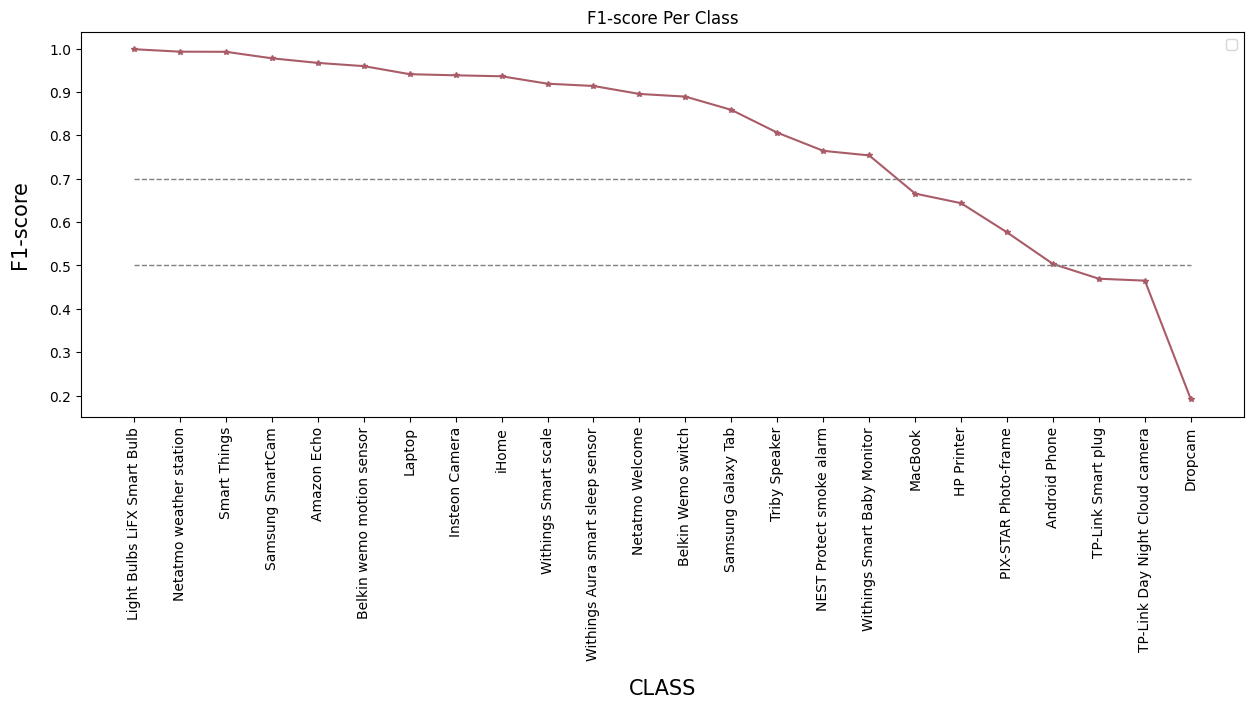

In [19]:
##### TEST
plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

In [21]:
# rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
# rf_opt.fit(X_train, y_train, sample_weight=weight_of_samples)
# y_pred_train = model.predict(X_train[feats])

# y_train = [int(label) for label in y_train]
# y_pred_train = [int(label) for label in y_pred_train]

# unique_label_train = train_data["Label"].unique()
# array_of_indices_train = []
# for lab in unique_label_train:
#     index = classes_df[classes_df['class'] == lab].index.values[0]
#     array_of_indices_train.append(index)
    
# # print(unique_label_train, array_of_indices_train)
# class_report = classification_report(y_train, y_pred_train, labels=array_of_indices_train, target_names=unique_label_train, output_dict = True)


In [22]:
# class_names = class_report.keys()
# score_per_class = []
# classes_ = []

# for c_name in class_names:
#     if c_name in classes:
#         score_per_class.append(class_report[c_name]['f1-score'])
#         classes_.append(c_name)
    
# score_per_class_df = pd.DataFrame({'class': classes_, 'f1_score': score_per_class})
# score_per_class_df = score_per_class_df.sort_values(by='f1_score', ascending=False)

In [23]:
# #### TRAIN
# plot_line([score_per_class_df['class'].to_list()], [score_per_class_df['f1_score'].to_list()], [], 'CLASS', 'F1-score', 'F1-score Per Class')

# PCFI

In [20]:
rf_opt = RandomForestClassifier(max_depth = depth, n_estimators = n_tree, random_state=42, bootstrap=False,n_jobs=10)
rf_opt.fit(X_train[feats], y_train, sample_weight=weight_of_samples)

RandomForestClassifier(bootstrap=False, max_depth=23, n_estimators=32,
                       n_jobs=10, random_state=42)

In [25]:
# from sklearn import tree
# tree.plot_tree(rf_opt.estimators_[0], feature_names=list(X_train.columns), filled=True)

In [26]:
# text_representation = tree.export_text(rf_opt.estimators_[0])
# print(text_representation)

In [21]:
### Matrix containing feature importances per feature-class pair
imp_mat = calcImportanceMatrix(rf_opt)

In [22]:
#### GET ordered classes and GET their features and feature importances in that order
imp_mat_ordered = []
score_per_class_df['f1_score'] = score_per_class_df['f1_score']*100
classes_ordered = score_per_class_df['class'].to_list()
class_scores_ordered = score_per_class_df['f1_score'].to_list()

for cl in classes_ordered:
    ind_of_class = classes.index(cl)
    imp_mat_ordered.append(imp_mat[ind_of_class])
    
## 2 classes which are not in TEST SET
classes_ordered.append('IPhone')
class_scores_ordered.append(0)
imp_mat_ordered.append(imp_mat[classes.index('IPhone')])
classes_ordered.append('Blipcare Blood Pressure meter')
class_scores_ordered.append(1)
imp_mat_ordered.append(imp_mat[classes.index('Blipcare Blood Pressure meter')])

In [23]:
# feature_names = feats_all
feature_names = feats

## Plots

#### Update plot

In [30]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.neighbors import KernelDensity

# # Generate some sample data
# np.random.seed(0)
# x = np.random.normal(0, 1, 1000)
# y = np.random.normal(0, 1, 1000)

# # Calculate local density using kernel density estimation
# kde = KernelDensity(bandwidth=0.5).fit(np.vstack([x, y]).T)
# density = np.exp(kde.score_samples(np.vstack([x, y]).T))

# # Normalize density to range [0, 1]
# density = (density - np.min(density)) / (np.max(density) - np.min(density))

# # Adjust values based on density
# adjusted_values = 1 - density  # Example adjustment formula

# # Plot adjusted scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(x, y, c=adjusted_values, cmap='viridis')
# plt.colorbar(label='Adjusted Values')
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.title('Scatter Plot with Adjusted Values Based on Density')
# plt.show()


In [24]:
x_scores = []
y_importances = []
c_name = []
f_name = []
exp_values = []
normalized_exp_values = []
normal_importances = []
log10_based = []
sum_of_importances_log10 = []
inverse_exp = []
for c in range(0, len(classes_ordered)):
    sum_exp_values = 0
    exp_values_per_class = []
    for f in range(0, len(feature_names)):
        c_name.append(classes_ordered[c])
        f_name.append(feature_names[f])
        x_scores.append(class_scores_ordered[c]/100)
        normal_importances.append(np.array(imp_mat_ordered)[c,f])
        try:
            if(np.array(imp_mat_ordered)[c,f] == 0):
                y_importances.append((1/(0.0001)/100))
            else:
                y_importances.append((1/(np.array(imp_mat_ordered)[c,f]*100)))
            exp_values.append(math.exp(y_importances[-1]))
        except:
            y_importances[-1] = 1/(0.0001)/100
            exp_values.append(math.exp(y_importances[-1]))
            
        # try:
        #     inverse_exp.append(math.log(np.array(imp_mat_ordered)[c,f])*100)
        # except:
        #     inverse_exp.append(100)
        # log10_based.append(math.log10(exp_values[-1]))
        # exp_values_per_class.append(exp_values[-1])
        # sum_exp_values = sum_exp_values + exp_values_per_class[-1]
    # sum_of_importances_log10.extend([sum(log10_based[-31:])]*31)
    # normalized_exp_values.extend([e/sum_exp_values for e in exp_values_per_class])
        

In [25]:
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'y_importances': y_importances, 'exp_values': exp_values, 'normalized_exp': normalized_exp_values,  'density': density})
# density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values, 'log10_based_exp': log10_based,'normalized_exp': normalized_exp_values, 'sum_of_importances_log10':sum_of_importances_log10, 'inverse_exp': inverse_exp})
density_df = pd.DataFrame({'c_name': c_name, 'f_name': f_name, 'x_scores': x_scores, 'normal_importances': normal_importances, 'y_importances': y_importances, 'exp_values': exp_values})

['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things', 'Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor', 'Laptop', 'Insteon Camera', 'iHome', 'Withings Smart scale', 'Withings Aura smart sleep sensor', 'Netatmo Welcome', 'Belkin Wemo switch', 'Samsung Galaxy Tab', 'Triby Speaker', 'NEST Protect smoke alarm', 'Withings Smart Baby Monitor', 'MacBook', 'HP Printer', 'PIX-STAR Photo-frame', 'Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera', 'Dropcam', 'IPhone', 'Blipcare Blood Pressure meter']


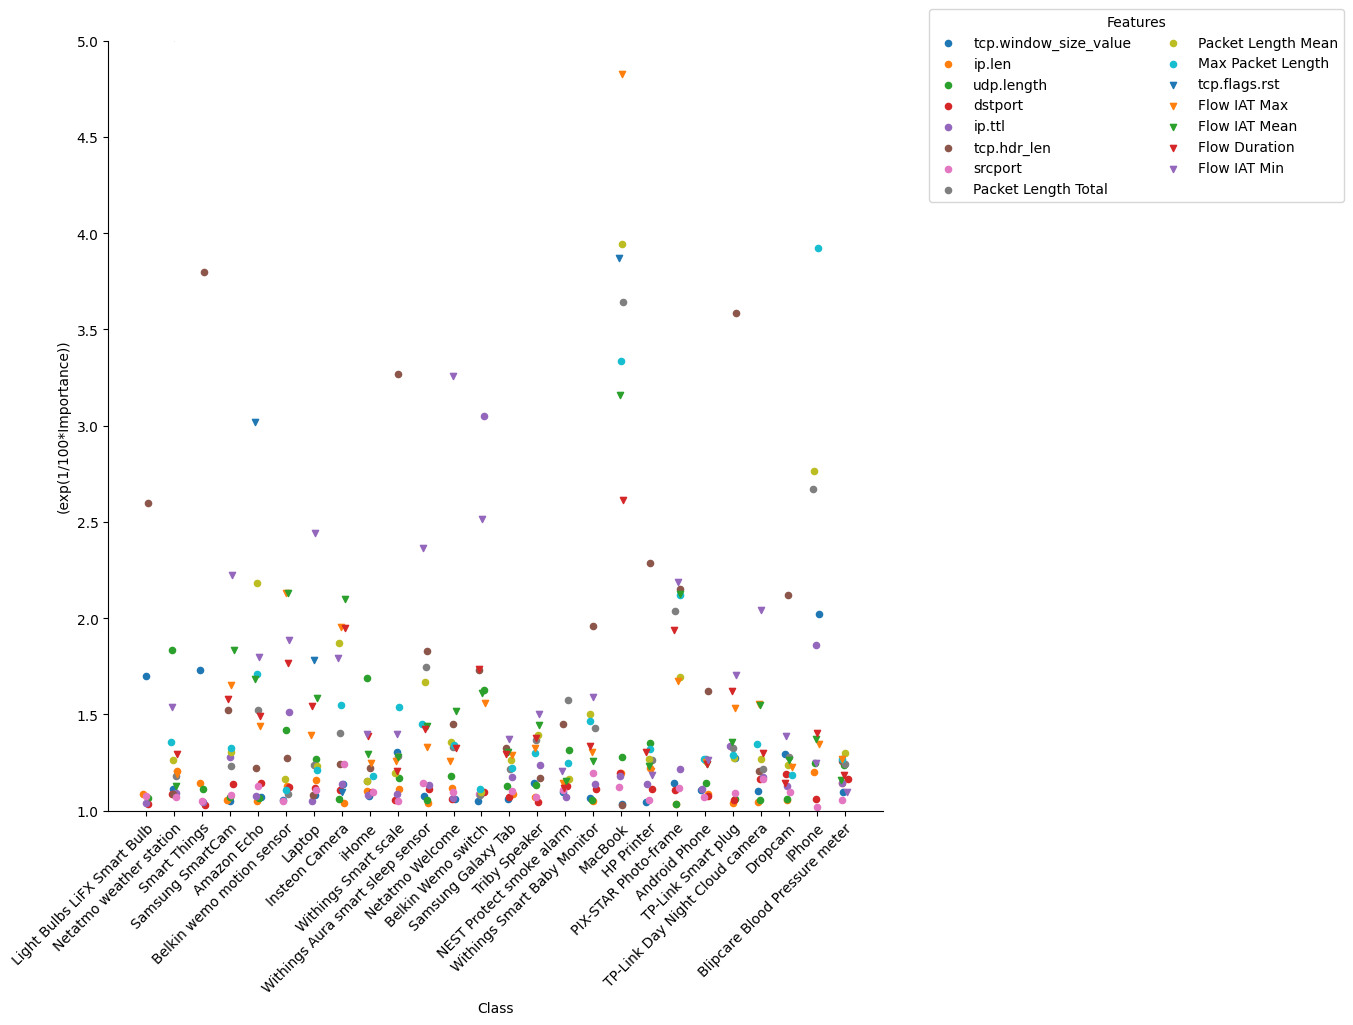

In [27]:
#importance distribution over classes
# imp_mat = calcImportanceMatrix(rf_opt)
importance_of_features = {}
marker_lst = [
    "o", "v", "*", "<"
]
color_lst = sns.color_palette(n_colors=10)
# print(len(color_lst))
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]

feature_names = feature_names
class_names = classes_ordered
len_class_names = len(class_names)
print(class_names)
fig, ax = plt.subplots(figsize=(10,10))
for j in np.arange(len(feature_names)):
    ax.scatter(
        # density_df[density_df['f_name']==feature_names[j]]['x_scores'].to_list(),
        np.arange(len_class_names) + np.random.uniform(-1,1,size=len_class_names)*.25/2.,
               density_df[density_df['f_name']==feature_names[j]]['exp_values'].to_list(), color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=20, label=feature_names[j])
    importance_of_features[feature_names[j]] = np.array(imp_mat_ordered)[:,j]
    # if j==20:
    #     break
    # print(imp_mat[:,j])
# ax.hlines(y=0.08, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('(exp(1/100*Importance))')
ax.set_ylim(bottom=0)
ax.set_ylim(1, 5)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


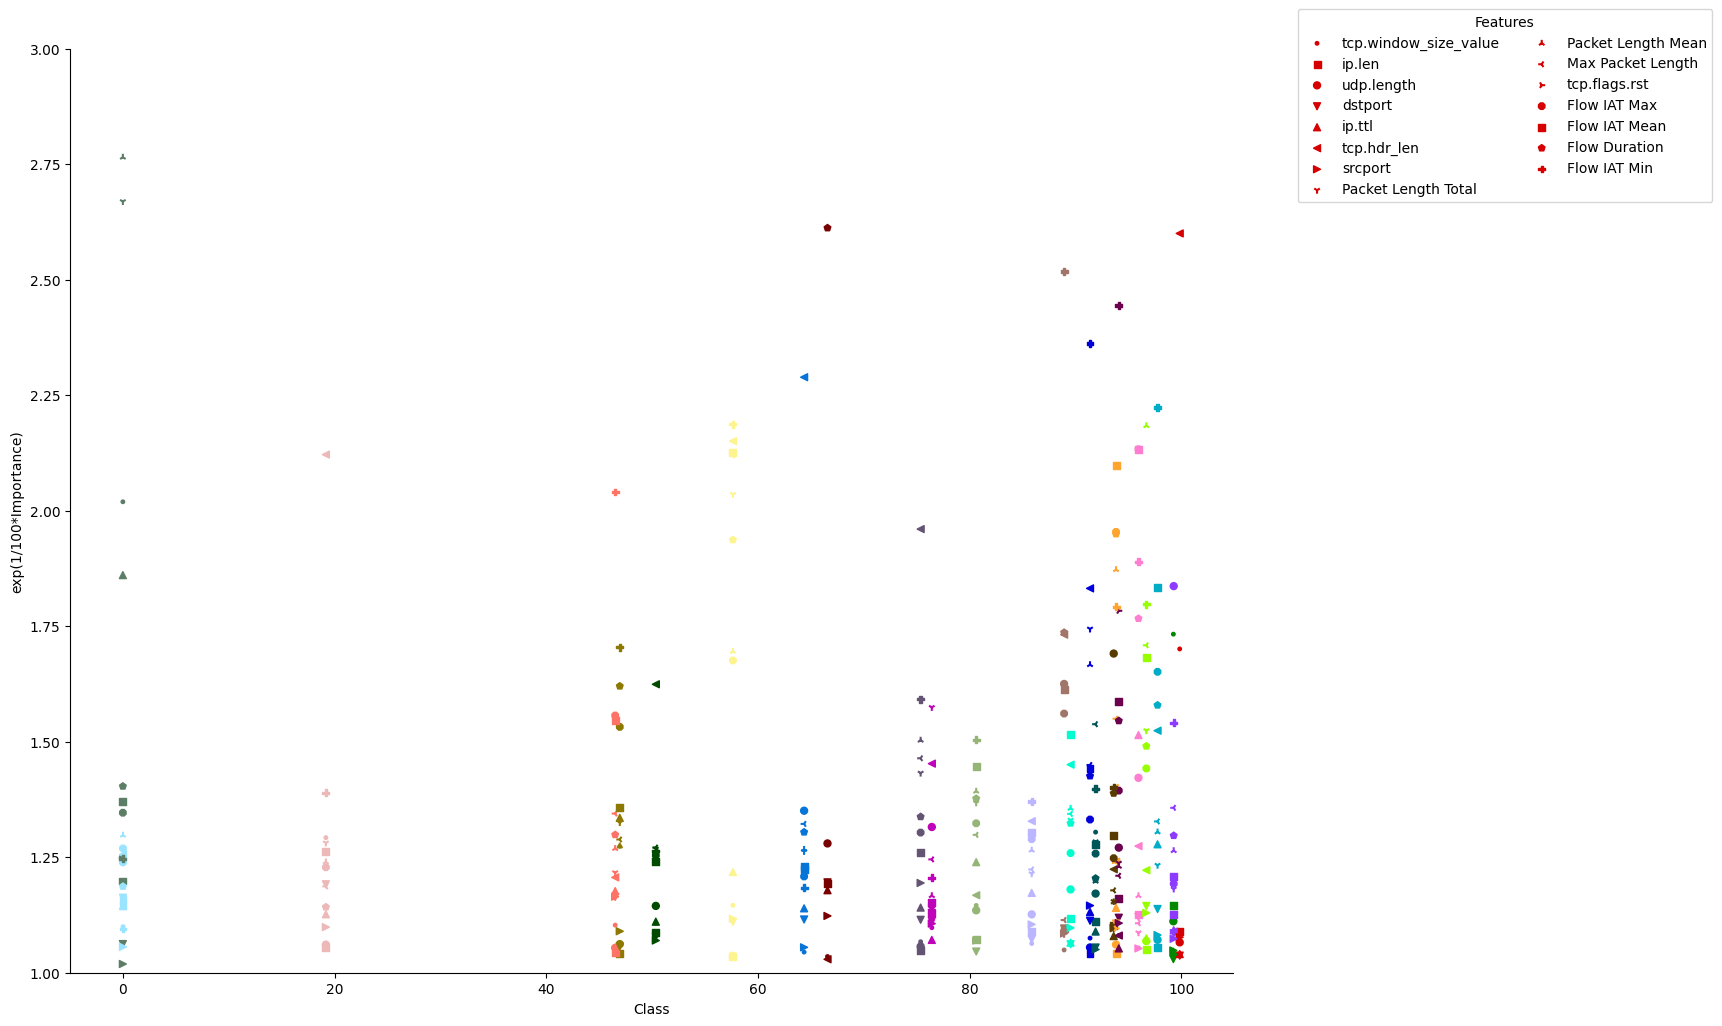

In [61]:
#### CLASS vs IMPORTANCE
## marker: to represent features
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feature_names
class_names = classes_ordered
len_class_names = len(class_names)
#
fig, ax = plt.subplots(figsize=(15,12))
for j in np.arange(len(feature_names)):
    ax.scatter(density_df[density_df['f_name']==feature_names[j]]['x_scores'].to_list(),
               density_df[density_df['f_name']==feature_names[j]]['exp_values'].to_list(), color=color_lst, marker=marker_lst[j],
               s=25, label=feature_names[j])
    # if j==15:
    #     break
## plot feature importance threshold
# ax.hlines(y=25, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
# ax.set_xticks(class_scores_ordered)
# ax.set_xticklabels(class_names, rotation=90, fontsize = 10)
ax.set_xlabel('Class')
ax.set_ylabel('exp(1/100*Importance)')
ax.set_ylim(bottom=0)
ax.set_ylim(1, 3)
# ax.set_xlim(0.4, 1)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


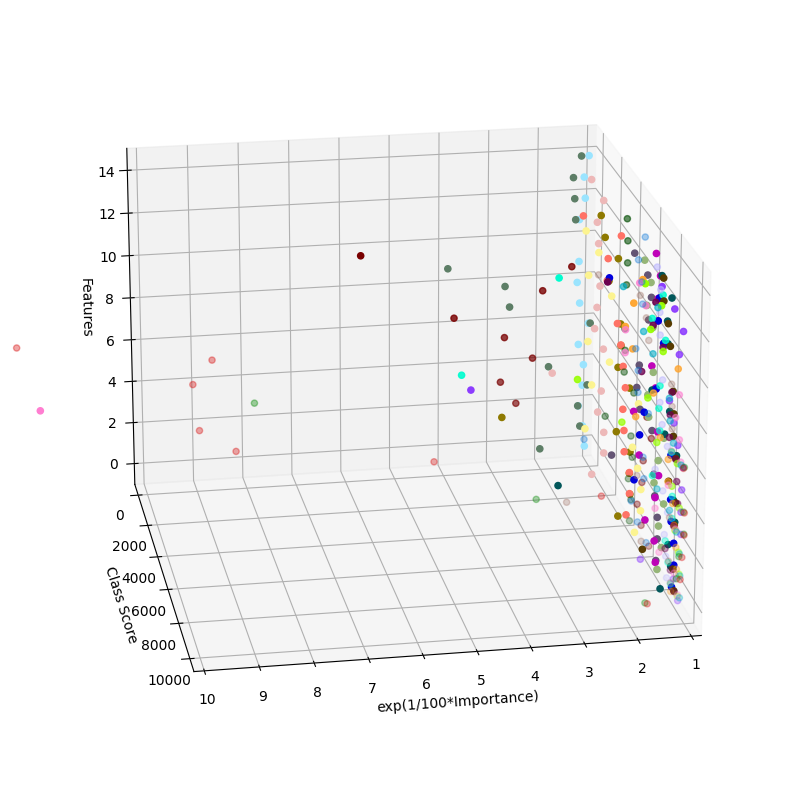

In [63]:
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
#
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection = '3d')
## PLOT
markers = ['*', '>', '.', ',']
for j in np.arange(len(classes_ordered)):
    c_name = classes_ordered[j]
    ax.scatter(density_df[density_df['c_name'] == c_name]['exp_values'].to_list(), [class_scores_ordered[j] for i in range(0,len(feature_names))], [i for i in range(len(feature_names))], color=color_lst[j], marker=".",
            s=80)
#
# ax.legend(bbox_to_anchor=(1, 1), title='Classes', ncol=1)
ax.set_xlabel('exp(1/100*Importance)')
ax.set_ylabel('Class Score')
ax.set_zlabel('Features')
ax.set_xlim(1,10)

# Customizing Viewing Angle
ax.view_init(elev=20, azim=80., roll=0)
plt.show()

#### The first versions

['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things', 'Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor', 'Laptop', 'Insteon Camera', 'iHome', 'Withings Smart scale', 'Withings Aura smart sleep sensor', 'Netatmo Welcome', 'Belkin Wemo switch', 'Samsung Galaxy Tab', 'Triby Speaker', 'NEST Protect smoke alarm', 'Withings Smart Baby Monitor', 'MacBook', 'HP Printer', 'PIX-STAR Photo-frame', 'Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera', 'Dropcam', 'IPhone', 'Blipcare Blood Pressure meter']


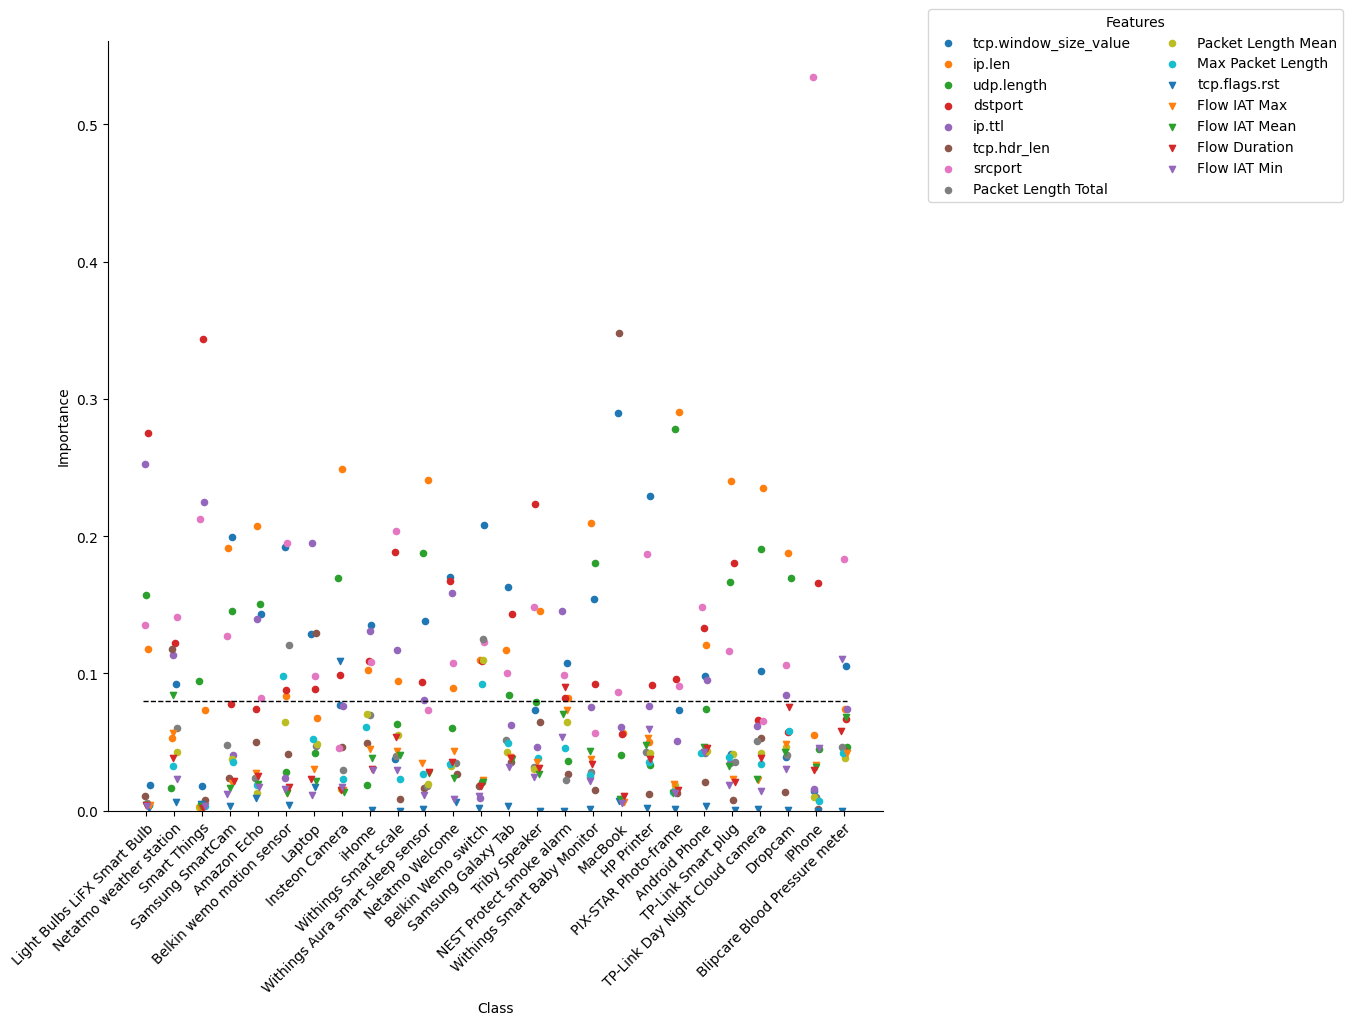

In [64]:
#importance distribution over classes
# imp_mat = calcImportanceMatrix(rf_opt)
importance_of_features = {}
marker_lst = [
    "o", "v", "*", "<"
]
color_lst = sns.color_palette(n_colors=10)
# print(len(color_lst))
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]

feature_names = feature_names
class_names = classes_ordered
len_class_names = len(class_names)
print(class_names)
fig, ax = plt.subplots(figsize=(10,10))
for j in np.arange(len(feature_names)):
    ax.scatter(np.arange(len_class_names) + np.random.uniform(-1,1,size=len_class_names)*.25/2.,
               np.array(imp_mat_ordered)[:,j], color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
               s=20, label=feature_names[j])
    importance_of_features[feature_names[j]] = np.array(imp_mat_ordered)[:,j]
    # print(imp_mat[:,j])
ax.hlines(y=0.08, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
ax.set_xticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
# ax.set_ylim(0.05, 0.1)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


#### Plot by setting x_axis as score per class

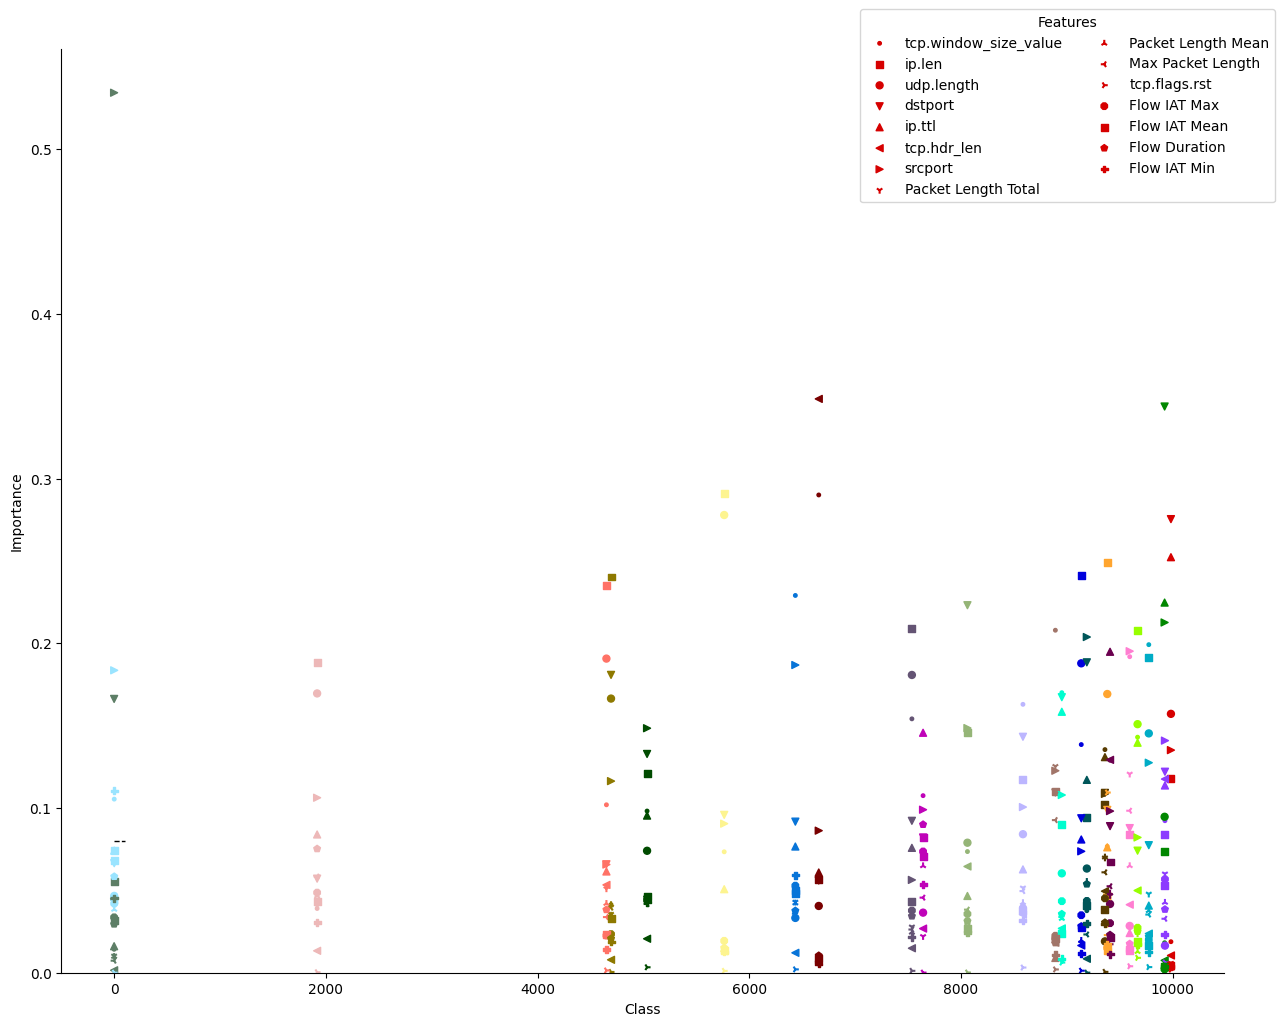

In [65]:
#### CLASS vs IMPORTANCE
## marker: to represent features
marker_lst = [
    ".", ",", "o", "v", "^", "<", ">", "1", "2", "3", "4", "8", "s", "p", "P", "*", "h", "H", "+", "x", "X",
    "D", "d", "|", "_", 0, 1, 2, 3, 4, 5
]
## color: to represent classes
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]
#
feature_names = feature_names
class_names = classes_ordered
len_class_names = len(class_names)
#
fig, ax = plt.subplots(figsize=(15,12))
for j in np.arange(len(feature_names)):
    ax.scatter(class_scores_ordered,
               np.array(imp_mat_ordered)[:,j], color=color_lst, marker=marker_lst[j],
               s=25, label=feature_names[j])
## plot feature importance threshold
ax.hlines(y=0.08, xmin=-0, xmax=100, colors='k', linestyles='dashed', lw=1)
ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
# ax.set_xticks(class_scores_ordered)
# ax.set_xticklabels(class_names, rotation=90, fontsize = 10)
ax.set_xlabel('Class')
ax.set_ylabel('Importance')
ax.set_ylim(bottom=0)
sns.despine(fig=fig)
#fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
plt.show()
plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


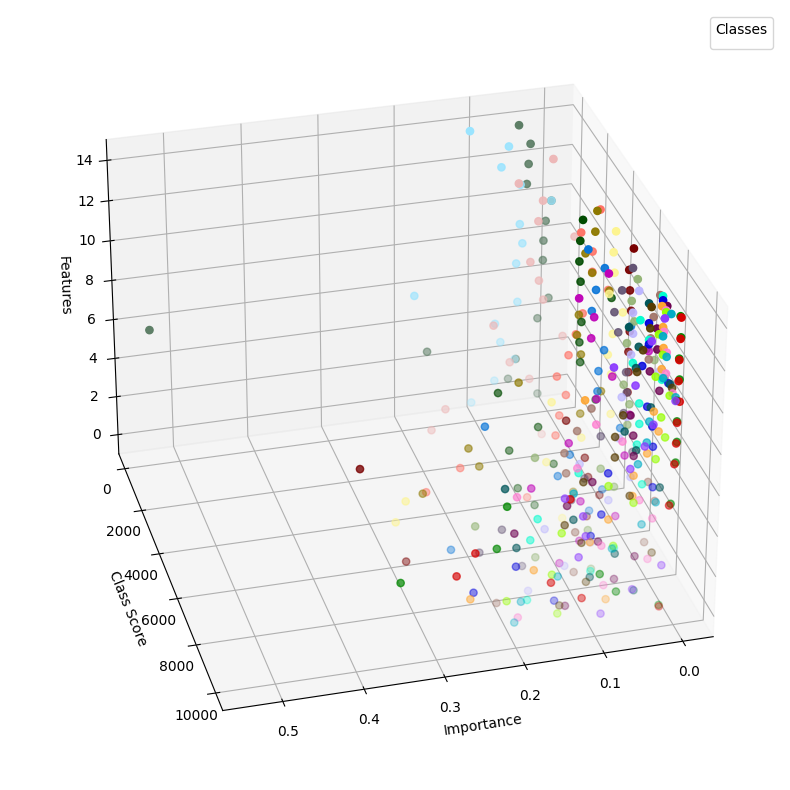

In [66]:
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
#
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(projection = '3d')
## PLOT
markers = ['*', '>', '.', ',']
for j in np.arange(len(classes_ordered)):
    ax.scatter(imp_mat_ordered[j], [class_scores_ordered[j] for i in range(0,len(feature_names))], [i for i in range(len(feature_names))], color=color_lst[j], marker=".",
            s=110)
#
ax.legend(bbox_to_anchor=(1, 1), title='Classes', ncol=1)
ax.set_xlabel('Importance')
ax.set_ylabel('Class Score')
ax.set_zlabel('Features')

# Customizing Viewing Angle
ax.view_init(elev=30, azim=75., roll=0)
plt.show()

In [39]:
# ##### 3D PLOT - ALL FEATURES
# fig = plt.figure(figsize=(12,10))
# ax = fig.add_subplot(111, projection = '3d')
# color_lst = sns.color_palette(cc.glasbey, n_colors=3)
# feature_best_10 = []
# importance_best_10 = [] 

# for j in np.arange(len(class_scores_ordered)):
#     ax.scatter(np.array(imp_mat_ordered)[j], [class_scores_ordered[j] for i in range(0,len(feature_names))], [i for i in range(1,len(feature_names)+1)], marker=marker_lst[:3], color=color_lst[j],
#                s=25)
# ax.set_xlabel('Importance')
# ax.set_ylabel('Class')
# ax.set_zlabel('Features')

# # ax.set_xlim3d(0.05, 0.4)

# # Customizing Viewing Angle
# ax.view_init(elev=20., azim=-85, roll=0)

# plt.show()

## PLOT for CLUSTERS

In [26]:
clusters = [['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things'],
            ['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor'],
            ['Laptop', 'Insteon Camera', 'iHome'],
            ['Withings Smart scale', 'Withings Aura smart sleep sensor'],
            ['Netatmo Welcome', 'Belkin Wemo switch'],
            ['Samsung Galaxy Tab'],
            ['Triby Speaker'],
            ['NEST Protect smoke alarm', 'Withings Smart Baby Monitor'],
            ['MacBook', 'HP Printer'],
            ['PIX-STAR Photo-frame'],
            ['Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera']]

In [27]:
def plot_3d_for_clusters(classes_in_name, classes_in_score, classes_in_indices, class_scores_ordered, imp_mat_ordered, feature_names, n_of_features, color_lst):
    ##### 3D PLOT - For specific classes
    # color_lst = sns.color_palette(cc.glasbey, n_colors=n_of_features)
    feature_best = []
    importance_best = []
    color_best = []
    #
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(projection = '3d')
    # Get features and importances for spacific classes
    for j in classes_in_indices:
        df_temp = pd.DataFrame({'feats': [i for i in range(1,len(feature_names)+1)], 'importance': np.array(imp_mat_ordered)[j]})
        # df_temp = df_temp[df_temp['importance']>0.05]
        # df_temp_ordered = df_temp.sort_values(by='importance', ascending=False).head(12)
        feature_best.append(df_temp['feats'].to_list())
        importance_best.append(df_temp['importance'].to_list())
        
        ### Match colors for the PLOT
        feats_temp_list = []
        for f in df_temp['feats'].to_list():
            feats_temp_list.append(color_lst[f-1])
        color_best.append(feats_temp_list)
        
    ## PLOT
    markers = ['*', '>', '.', ',']
    for j in np.arange(len(classes_in_name)):
        class_index = 0
        ax.scatter(importance_best[j], [class_scores_ordered[classes_in_indices[class_index]] for i in range(0,len(feature_best[j]))], feature_best[j], color=color_best[j], marker=markers[j],
                s=150, label=classes_in_name[j])    
        class_index = class_index + 1
    #
    ax.legend(bbox_to_anchor=(1, 1), title='Classes', ncol=1)
    ax.set_xlabel('Importance')
    ax.set_ylabel('Class')
    ax.set_zlabel('Features')
    
    leg = ax.get_legend()
    try:
        leg.legendHandles[0].set_color('gray')
        leg.legendHandles[1].set_color('gray')
        leg.legendHandles[2].set_color('gray')
    except:
        print('legend warning!')

    # Customizing Viewing Angle
    ax.view_init(elev=0., azim=90, roll=0)
    plt.show()

In [28]:
def calculate_overall_importance(classes_in_name, classes_in_indices, imp_mat_ordered, feature_names):
    print(classes_in_name)
    total_feature_importance = {}
    feats_index = 0
    for f in feature_names:
        total_importance = 0
        for c in classes_in_indices:
            total_importance = total_importance + imp_mat_ordered[c][feats_index]
        total_feature_importance[f] = total_importance
        feats_index = feats_index + 1
    
    overall_importance_df = pd.DataFrame({'features': total_feature_importance.keys(), 'total_importance': total_feature_importance.values()})
    overall_importance_df['normalized_importance'] = overall_importance_df['total_importance']/len(classes_in_name)
    return overall_importance_df

In [29]:
def plot_overall_importance(overall_importance_df, classes_in, n_of_features):
    ## PLOT 
    fig = plt.figure(figsize=(8,6))
    #
    plt.scatter(overall_importance_df['features'], overall_importance_df['normalized_importance'].to_list(), color=overall_importance_df['color'], s=80)  
    plt.hlines(y=0.05, xmin=-.25/2., xmax=len(feature_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
    plt.xticks(rotation=90)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(str(classes_in))

In [30]:
def plot_cdf(data):
    # getting data of the histogram 
    count, bins_count = np.histogram(data, bins=7) 
    
    # finding the PDF of the histogram using count values 
    pdf = count / sum(count) 
    
    # using numpy np.cumsum to calculate the CDF 
    # We can also find using the PDF values by looping and adding 
    cdf = np.cumsum(pdf) 
    
    # plotting PDF and CDF 
    plt.plot(bins_count[1:], pdf, color="red", label="PDF") 
    plt.plot(bins_count[1:], cdf, label="CDF") 
    plt.legend() 

In [31]:
### color for PLOT
color_lst = sns.color_palette(cc.glasbey, n_colors=len(feature_names))

In [32]:
overall_importance_X = calculate_overall_importance([clusters[0][0]], [0], imp_mat_ordered, feature_names)
overall_importance_X['color'] = color_lst
overall_importance_X_sorted = overall_importance_X.sort_values(by='total_importance', ascending=False)

['Light Bulbs LiFX Smart Bulb']


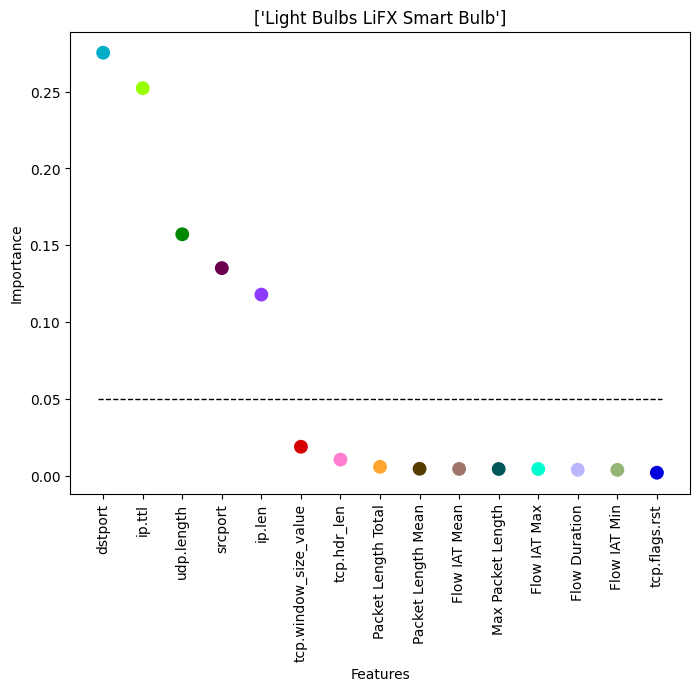

In [115]:
plot_overall_importance(overall_importance_X_sorted, [clusters[0][0]], len(feature_names))

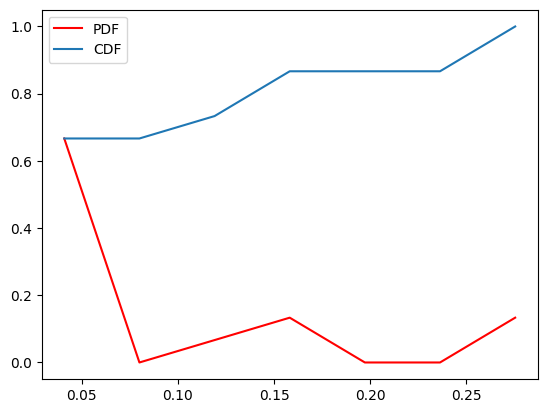

In [118]:
plot_cdf(overall_importance_X_sorted['total_importance'])

In [119]:
overall_importance_X = calculate_overall_importance([clusters[0][1]], [1], imp_mat_ordered, feature_names)
overall_importance_X['color'] = color_lst
overall_importance_X_sorted = overall_importance_X.sort_values(by='total_importance', ascending=False)

['Netatmo weather station']


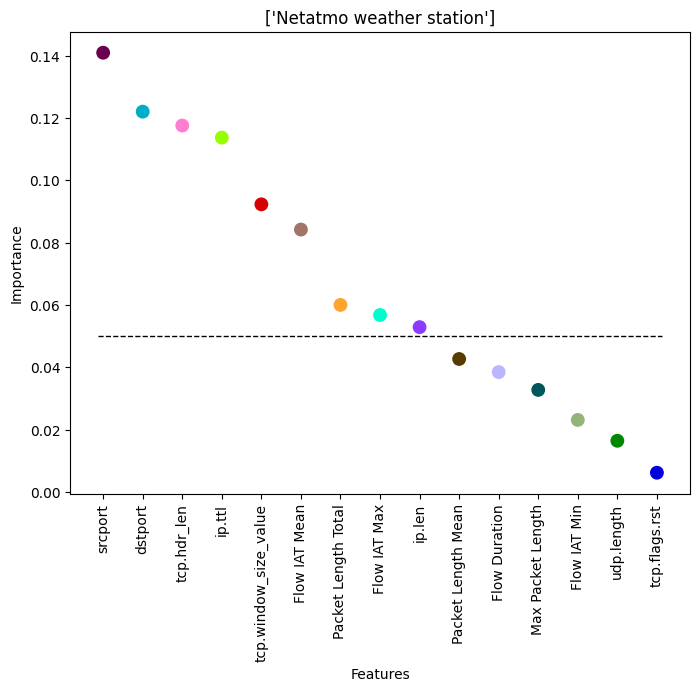

In [120]:
plot_overall_importance(overall_importance_X_sorted, [clusters[0][1]], len(feature_names))

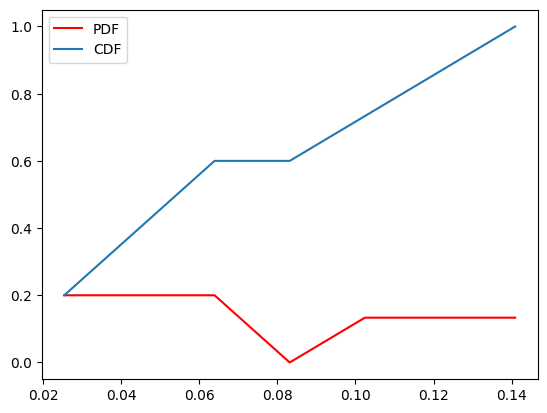

In [121]:
plot_cdf(overall_importance_X_sorted['total_importance'])

In [122]:
overall_importance_X = calculate_overall_importance([clusters[0][2]], [2], imp_mat_ordered, feature_names)
overall_importance_X['color'] = color_lst
overall_importance_X_sorted = overall_importance_X.sort_values(by='total_importance', ascending=False)

['Smart Things']


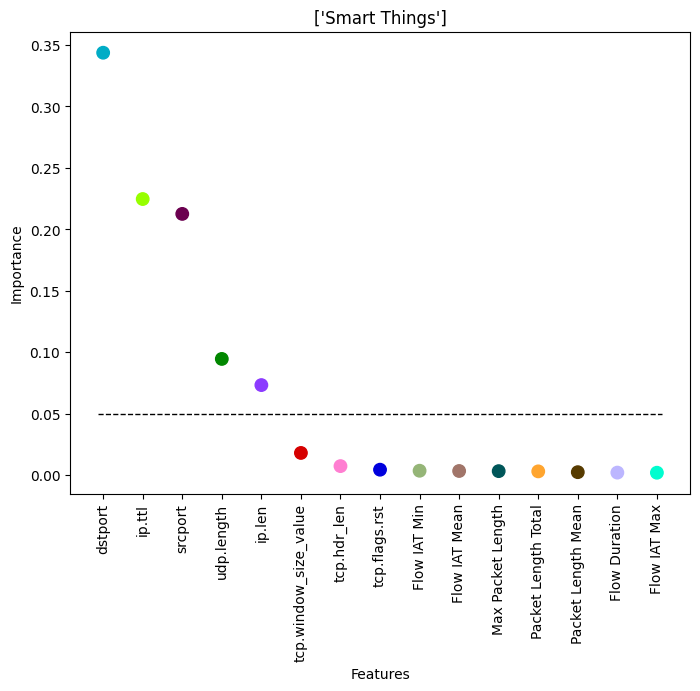

In [123]:
plot_overall_importance(overall_importance_X_sorted, [clusters[0][2]], len(feature_names))

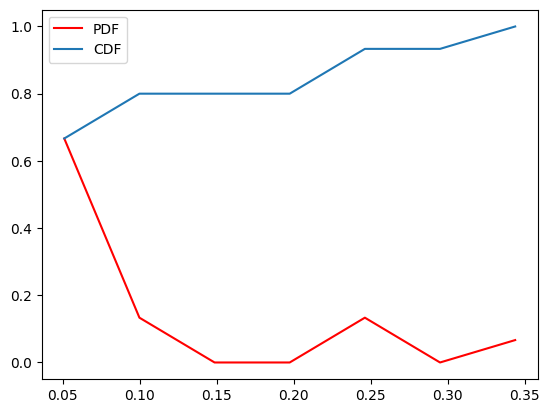

In [124]:
plot_cdf(overall_importance_X_sorted['total_importance'])

In [46]:
overall_importance_X = calculate_overall_importance([clusters[2][1]], [7], imp_mat_ordered, feature_names)
overall_importance_X['color'] = color_lst
overall_importance_X_sorted = overall_importance_X.sort_values(by='total_importance', ascending=False)

['Insteon Camera']


In [47]:
clusters

[['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things'],
 ['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor'],
 ['Laptop', 'Insteon Camera', 'iHome'],
 ['Withings Smart scale', 'Withings Aura smart sleep sensor'],
 ['Netatmo Welcome', 'Belkin Wemo switch'],
 ['Samsung Galaxy Tab'],
 ['Triby Speaker'],
 ['NEST Protect smoke alarm', 'Withings Smart Baby Monitor'],
 ['MacBook', 'HP Printer'],
 ['PIX-STAR Photo-frame'],
 ['Android Phone', 'TP-Link Smart plug', 'TP-Link Day Night Cloud camera']]

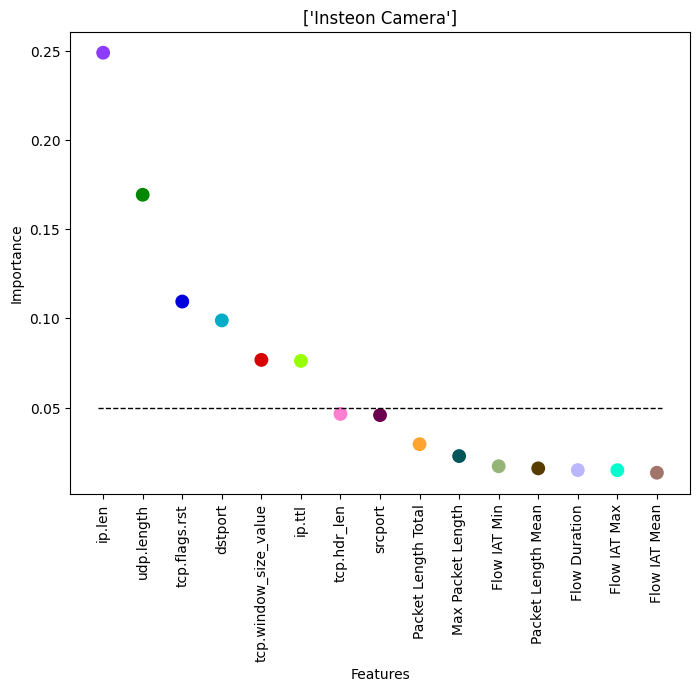

In [48]:
plot_overall_importance(overall_importance_X_sorted, [clusters[2][1]], len(feature_names))

### Per Cluster

In [75]:
overall_importance_CL1 = calculate_overall_importance(clusters[0], [0,1,2], imp_mat_ordered, feature_names)
overall_importance_CL1['color'] = color_lst
overall_importance_CL1_sorted = overall_importance_CL1.sort_values(by='normalized_importance', ascending=False)

['Light Bulbs LiFX Smart Bulb', 'Netatmo weather station', 'Smart Things']


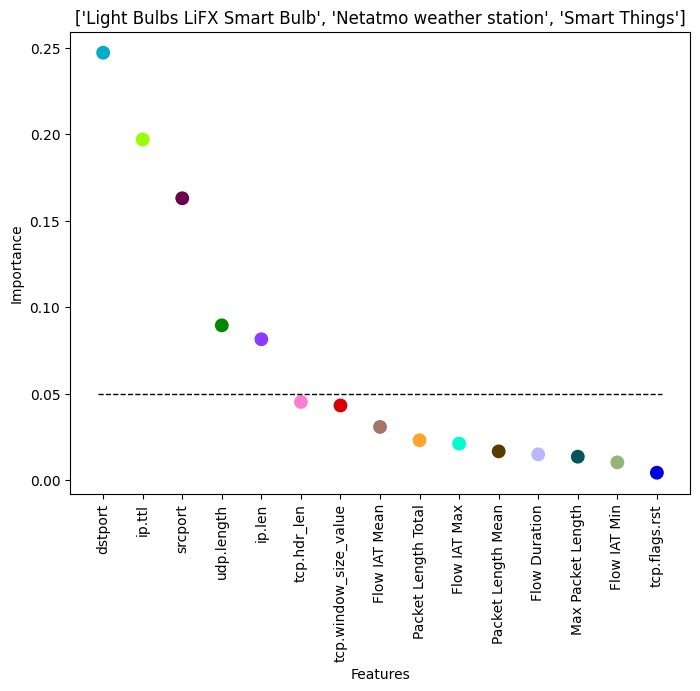

In [76]:
plot_overall_importance(overall_importance_CL1_sorted, clusters[0], 31)

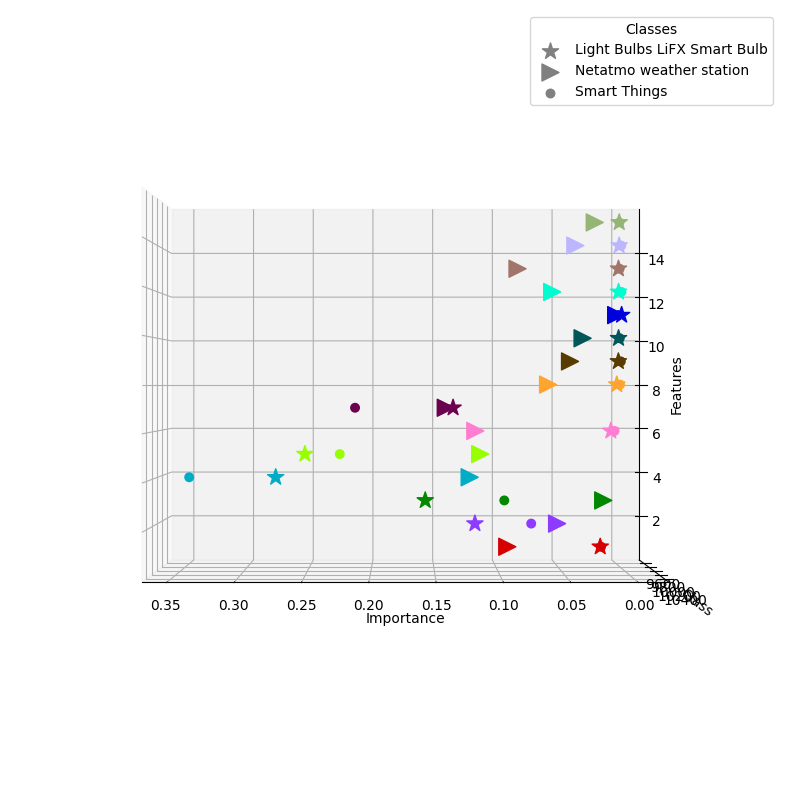

In [77]:
plot_3d_for_clusters(clusters[0], class_scores_ordered[0:3], [0,1,2], class_scores_ordered, imp_mat_ordered, feature_names, 31, overall_importance_CL1['color'])

In [78]:
overall_importance_CL2 = calculate_overall_importance(clusters[1], [3,4,5], imp_mat_ordered, feature_names)
overall_importance_CL2['color'] = color_lst
overall_importance_CL2_sorted = overall_importance_CL2.sort_values(by='normalized_importance', ascending=False)

['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor']


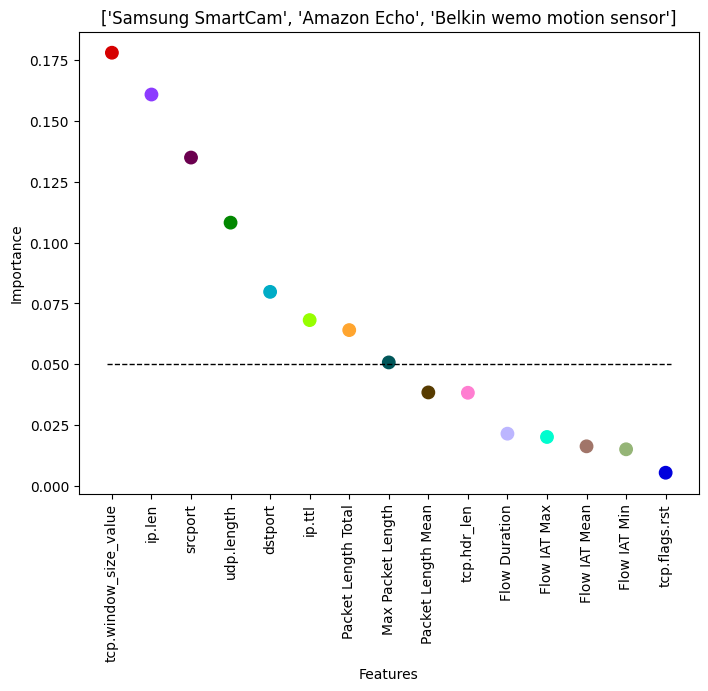

In [79]:
plot_overall_importance(overall_importance_CL2_sorted, clusters[1], 31)

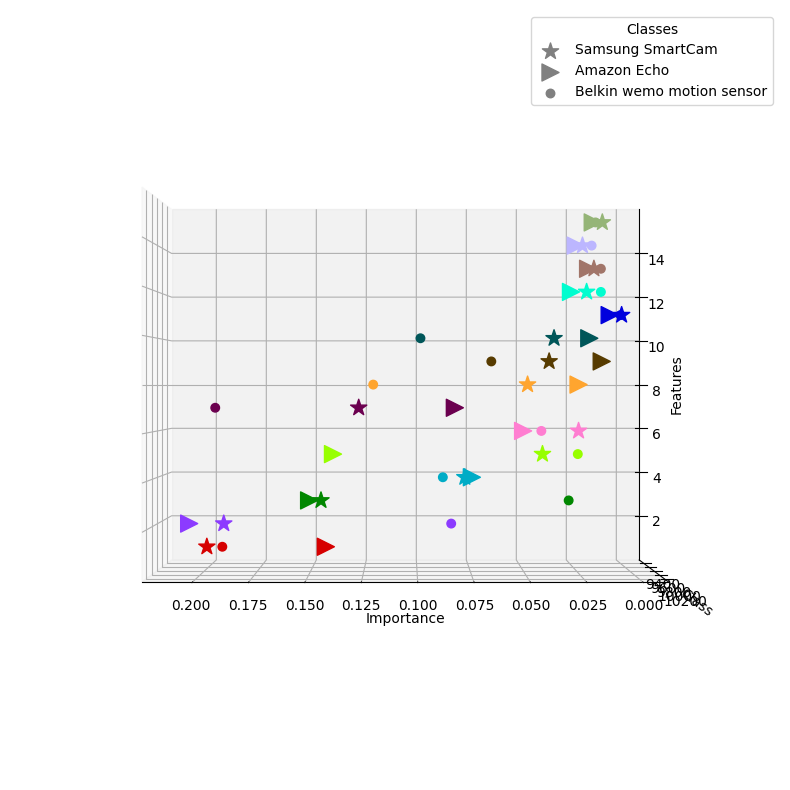

In [80]:
plot_3d_for_clusters(clusters[1], class_scores_ordered[3:6], [3,4,5], class_scores_ordered, imp_mat_ordered, feature_names, 31, overall_importance_CL2['color'])

In [81]:
overall_importance_CL3 = calculate_overall_importance(clusters[2], [6,7,8], imp_mat_ordered, feature_names)
overall_importance_CL3['color'] = color_lst
overall_importance_CL3_sorted = overall_importance_CL3.sort_values(by='normalized_importance', ascending=False)

['Laptop', 'Insteon Camera', 'iHome']


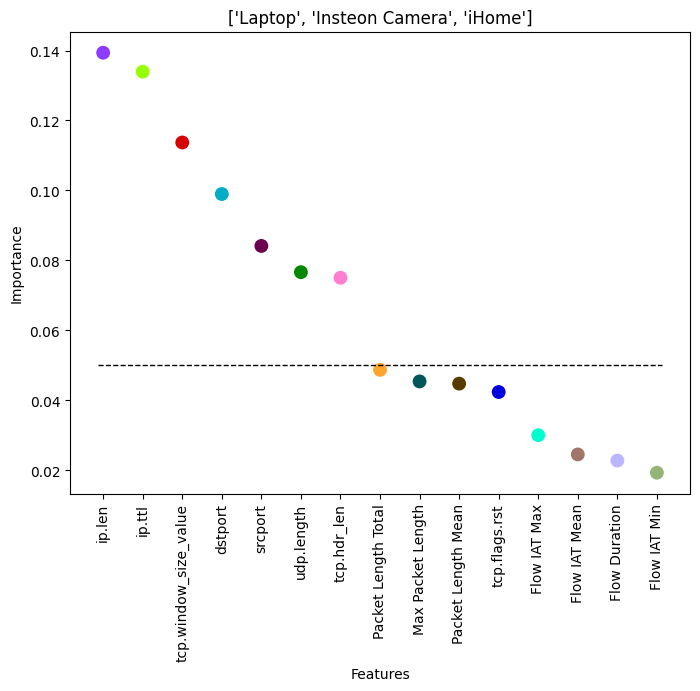

In [82]:
plot_overall_importance(overall_importance_CL3_sorted, clusters[2], 31)

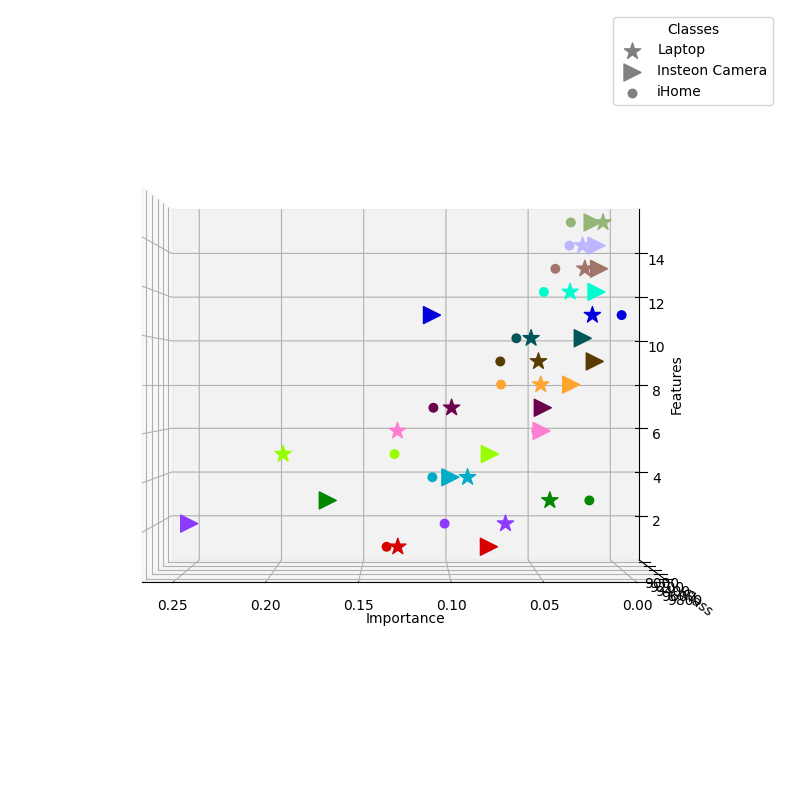

In [83]:
plot_3d_for_clusters(clusters[2], class_scores_ordered[6:9], [6,7,8], class_scores_ordered, imp_mat_ordered, feature_names, 31, overall_importance_CL3['color'])

In [84]:
overall_importance_CL4 = calculate_overall_importance(clusters[3], [9,10], imp_mat_ordered, feature_names)
overall_importance_CL4['color'] = color_lst
overall_importance_CL4_sorted = overall_importance_CL4.sort_values(by='normalized_importance', ascending=False)

['Withings Smart scale', 'Withings Aura smart sleep sensor']


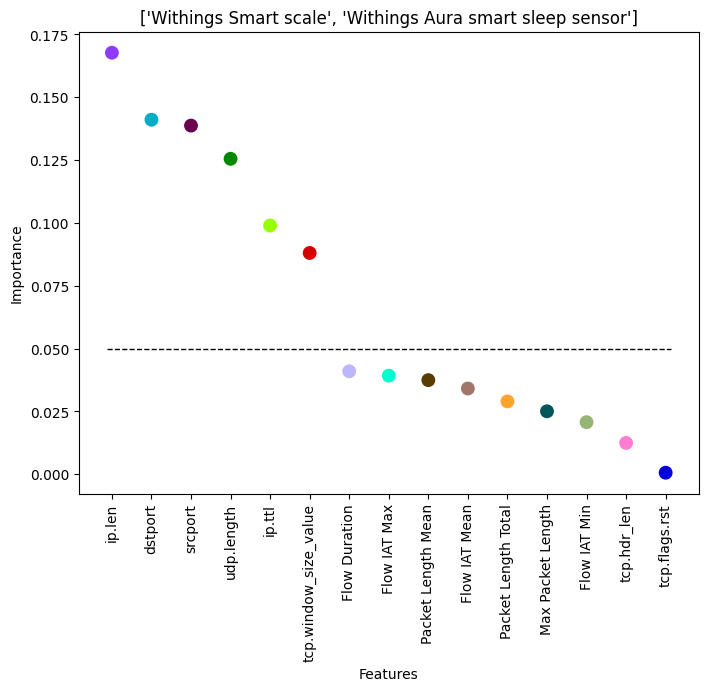

In [85]:
plot_overall_importance(overall_importance_CL4_sorted, clusters[3], 31)

legend warning!


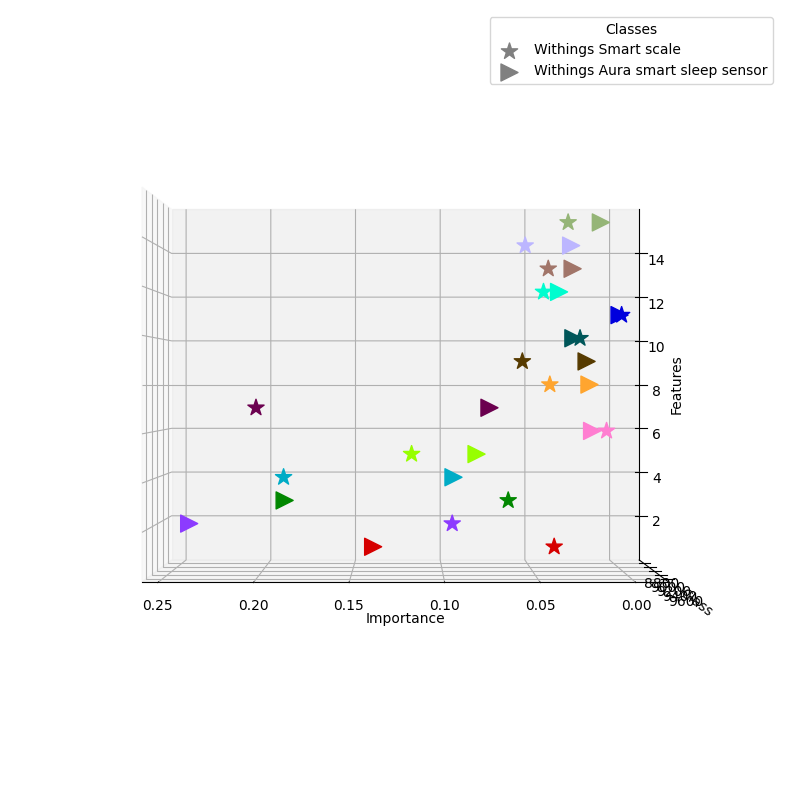

In [86]:
plot_3d_for_clusters(clusters[3], class_scores_ordered[9:11], [9,10], class_scores_ordered, imp_mat_ordered, feature_names, 31, overall_importance_CL4['color'])

In [87]:
##### 3D PLOT
import plotly.express as px
# fig = plt.figure(figsize=(10,6))
# ax = fig.add_subplot(projection = '3d')
color_lst = sns.color_palette(cc.glasbey, n_colors=26)
feature_best_10 = []
importance_best_10 = []
score_best_10 = []
color_best_10 = []
#### BEST 10 features
for j in np.arange(len(class_scores_ordered)):
    df_temp = pd.DataFrame({'feats': [i for i in range(1,len(feature_names)+1)], 'importance': np.array(imp_mat_ordered)[j]})
    df_temp_ordered = df_temp.sort_values(by='importance', ascending=False).head(10)
    feature_best_10.extend(df_temp_ordered['feats'].to_list())
    importance_best_10.extend(df_temp_ordered['importance'].to_list())
    score_best_10.extend([class_scores_ordered[j] for i in range(0, 10)])
    color_best_10.extend([color_lst[j] for i in range(0, 10)])
##
data = {'Importance': importance_best_10, 'Class': score_best_10, 'Feature': feature_best_10}
df = pd.DataFrame(data)
# Create the 3D scatter plot using plotly.express
fig = px.scatter_3d(df, x='Importance', y='Class', z='Feature', color=color_best_10, size=[5 for i in range(len(color_best_10))])
##
fig.update_layout(scene=dict(
    xaxis_title='Importance',
    yaxis_title='Class',
    zaxis_title='Feature'
))
fig.update_layout(title='3D Scatter Plot')
# Display the plot
fig.show()

In [136]:
# #importance distribution over classes
# # imp_mat = calcImportanceMatrix(rf_opt)
# importance_of_features = {}
# marker_lst = [
#     "o", "v", "*", "<"
# ]
# color_lst = sns.color_palette(n_colors=10)
# # print(len(color_lst))
# color_marker_lst = [(c,m) for m in marker_lst for c in color_lst]

# feature_names = feats_all
# class_names = classes
# len_class_names = len(class_names)
# print(class_names)
# fig, ax = plt.subplots(figsize=(10,10))
# for j in np.arange(len(feature_names)):
#     ax.scatter(np.arange(len_class_names) + np.random.uniform(-1,1,size=len_class_names)*.25/2.,
#                imp_mat[:,j], color=color_marker_lst[j][0], marker=color_marker_lst[j][1],
#                s=20, label=feature_names[j])
#     importance_of_features[feature_names[j]] = imp_mat[:,j]
#     # print(imp_mat[:,j])
# ax.hlines(y=0.1, xmin=-.25/2., xmax=len(class_names)-1+.25/2., colors='k', linestyles='dashed', lw=1)
# ax.legend(bbox_to_anchor=(1.05, 1.05), title='Features', ncol=2)
# ax.set_xticks(np.arange(len(class_names)))
# ax.set_xticklabels(class_names, rotation=45, ha='right', rotation_mode='anchor')
# ax.set_xlabel('Class')
# ax.set_ylabel('Importance')
# ax.set_ylim(bottom=0)
# sns.despine(fig=fig)
# #fig.savefig(fig_path+'/feature_importance_distribution_in_classes.pdf', bbox_inches='tight')
# plt.show()
# plt.close()

In [33]:
#### CHOOSE BEST COMMON FEATURES
# classes_ordered_features = []
# classes_ordered_feature_values = []
# classes_ordered_6_features = []
# classes_ordered_6_feature_values = []
# classes_ordered_5_features = []
# classes_ordered_great_007 = []
# classes_ordered_great_008 = []
# score_per_class_list = score_per_class_df['f1_score'].to_list()
# score_per_class_list.extend([0,0])
# print(len(score_per_class_list))
# ind = 0
# for cl in classes_ordered:
#     df_temp = pd.DataFrame({'feature_name': feats_all, 'values': imp_mat_ordered[ind]})
#     ind = ind + 1
#     df_temp = df_temp.sort_values(by='values', ascending=False)
#     feature_names = df_temp['feature_name'].to_list()
#     feature_values = df_temp['values'].to_list()
#     classes_ordered_features.append(feature_names)
#     classes_ordered_feature_values.append(feature_values)
#     classes_ordered_6_features.append(feature_names[:6])
#     classes_ordered_6_feature_values.append(feature_values[:6])
#     classes_ordered_5_features.append(feature_names[:5])
#     #
#     df_temp_filtered = df_temp[df_temp['values'] > 0.07]
#     classes_ordered_great_007.append(df_temp_filtered['feature_name'].to_list())
#     df_temp_filtered = df_temp[df_temp['values'] > 0.08]
#     classes_ordered_great_008.append(df_temp_filtered['feature_name'].to_list())
# class_feature_analysis = pd.DataFrame({'Class': classes_ordered, 'f1_score':score_per_class_list, 'features_>_0.08_importance':classes_ordered_great_008, 'features_>_0.07_importance':classes_ordered_great_007, 'features_best_5': classes_ordered_5_features, 'features_best_6': classes_ordered_6_features, 'importances_best_6': classes_ordered_6_feature_values})
    

#### classes = ['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb', 'Other']
#### feats_important = ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']

In [28]:
model_analysis_3CL = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_4CLASS_IMPORTANT_FEATURES.csv'])

In [29]:
threshold_score = 0.99
model_analysis_3CL['c_report_FL_99'] = model_analysis_3CL['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_3CL['succ_classes_FL_99'] = model_analysis_3CL['c_report_FL_99'].apply(find_successful_classes)
model_analysis_3CL['COUNT_succ_classes_FL_99'] = model_analysis_3CL['succ_classes_FL_99'].apply(count_succ_classes)
###
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_3CL['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_3CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_3CL['score_Netatmo_Weather_station'] = model_analysis_3CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_3CL['score_Smart_Things'] = model_analysis_3CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Other'
model_analysis_3CL['Other'] = model_analysis_3CL['c_report_FL_99'].apply(get_score_of_classes)

In [30]:
model_analysis_3CL[model_analysis_3CL['COUNT_succ_classes_FL_99']==4].head(10)[['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'Micro_f1_FL', 'score_Light_Bulbs_LiFX_Smart_Bulb', 'score_Netatmo_Weather_station', 'score_Smart_Things', 'Other']].sort_values(by='no_feats')

depth  tree  no_feats                                              feats  \
45      12     1         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
57      14     1         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
63      15     1         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
69      16     1         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
153      9     2         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
279      9     3         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
285     10     3         4     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
202     17     2         5  ['dstport', 'ip.ttl', 'udp.length', 'srcport',...   
208     18     2         5  ['dstport', 'ip.ttl', 'udp.length', 'srcport',...   
214     19     2         5  ['dstport', 'ip.ttl', 'udp.length', 'srcport',...   

     Macro_f1_FL  Weighted_f1_FL  Micro_f1_FL  \
45      0.996300        0.999747     0.999747   
57      0.995263        0.999697     0.999698   
63      0.996685        0.999796     0.999796   
69      0.996685        0.999796     0.999796   
153     0.995254        0.999588     0.999588   
279     0.996159        0.999714     0.999714   
285     0.996919        0.999763     0.999763   
202     0.995338        0.999637     0.999637   
208     0.995468        0.999687     0.999686   
214     0.994769        0.999601     0.999600   

     score_Light_Bulbs_LiFX_Smart_Bulb  score_Netatmo_Weather_station  \
45                            0.998011                       0.991970   
57                            0.999006                       0.991970   
63                            0.998675                       0.991970   
69                            0.998675                       0.991970   
153                           0.996121                       0.993915   
279                           0.998011                       0.993915   
285                           0.997677                       0.993915   
202                           0.996684                       0.991590   
208                           0.998015                       0.991590   
214                           0.996931                       0.991590   

     score_Smart_Things     Other  
45             0.995353  0.999868  
57             0.990234  0.999843  
63             0.996201  0.999894  
69             0.996201  0.999894  
153            0.991195  0.999786  
279            0.992860  0.999851  
285            0.996207  0.999877  
202            0.993266  0.999811  
208            0.992431  0.999837  
214            0.990764  0.999792

In [ ]:
# 14	Light Bulbs LiFX Smart Bulb	99.836551
# 15	Netatmo weather station	99.271827
# 19	Smart Things	99.239209

#### classes = ['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb', 'Samsung SmartCam', 'Amazon Echo', 'Other']
#### feats_important = ['dstport','ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']

In [28]:
model_analysis_6CL = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_6CLASS_7_IMPORTANT_FEATURES.csv'])

In [29]:
threshold_score = 0.99
model_analysis_6CL['c_report_FL_99'] = model_analysis_6CL['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_6CL['succ_classes_FL_99'] = model_analysis_6CL['c_report_FL_99'].apply(find_successful_classes)
model_analysis_6CL['COUNT_succ_classes_FL_99'] = model_analysis_6CL['succ_classes_FL_99'].apply(count_succ_classes)
###
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_6CL['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_6CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_6CL['score_Netatmo_Weather_station'] = model_analysis_6CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_6CL['score_Smart_Things'] = model_analysis_6CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Samsung SmartCam'
model_analysis_6CL['score_Samsung_SmartCam'] = model_analysis_6CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Amazon Echo'
model_analysis_6CL['score_Amazon_Echo'] = model_analysis_6CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Other'
model_analysis_6CL['Other'] = model_analysis_6CL['c_report_FL_99'].apply(get_score_of_classes)

In [35]:
model_analysis_6CL[model_analysis_6CL['COUNT_succ_classes_FL_99']>2].head(15)[['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'score_Light_Bulbs_LiFX_Smart_Bulb', 'score_Netatmo_Weather_station', 'score_Smart_Things','score_Samsung_SmartCam', 'score_Amazon_Echo', 'Other']].sort_values(by='Macro_f1_FL', ascending=False)

depth  tree  no_feats  \
251     19     2         7   
221     15     2         5   
256     20     2         5   
235     17     2         5   
382     17     3         5   
391     18     3         7   
384     17     3         7   
265     21     2         7   
88      17     1         5   
353     13     3         4   
185     10     2         4   
332     10     3         4   
213     14     2         4   
66      14     1         4   
367     15     3         4   

                                                                                                 feats  \
251  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
221                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
256                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
235                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
382                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
391  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
384  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
265  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
88                             ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
353                                                     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
185                                                     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
332                                                     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
213                                                     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
66                                                      ['dstport', 'ip.ttl', 'udp.length', 'srcport']   
367                                                     ['dstport', 'ip.ttl', 'udp.length', 'srcport']   

     Macro_f1_FL  score_Light_Bulbs_LiFX_Smart_Bulb  \
251     0.983955                           0.998197   
221     0.982788                           0.998345   
256     0.981453                           0.996689   
235     0.980833                           0.994271   
382     0.980034                           0.998012   
391     0.972679                           0.996758   
384     0.971617                           0.996649   
265     0.970326                           0.997091   
88      0.965097                           0.992382   
353     0.907119                           0.995853   
185     0.904786                           0.993533   
332     0.904326                           0.993190   
213     0.903510                           0.993403   
66      0.901976                           0.993064   
367     0.896439                           0.995018   

     score_Netatmo_Weather_station  score_Smart_Things  \
251                       0.994479            0.994860   
221                       0.991970            0.994156   
256                       0.991970            0.994574   
235                       0.991970            0.994574   
382                       0.991970            0.995795   
391                       0.993915            0.994540   
384                       0.995910            0.994391   
265                       0.990219            0.994720   
88                        0.991970            0.994574   
353                       0.995951            0.997893   
185                       0.993915            0.997473   
332                       0.993915            0.994958   
213                       0.991970            0.994540   
66                        0.991970            0.992027   
367                       0.993915            0.995376   

     score_Samsun

#### classes = ['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb', 'Samsung SmartCam', 'Other']
#### feats_important = ['dstport','ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']

In [36]:
model_analysis_5CL = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_5CLASS_7_IMPORTANT_FEATURES.csv'])

In [37]:
threshold_score = 0.99
model_analysis_5CL['c_report_FL_99'] = model_analysis_5CL['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_5CL['succ_classes_FL_99'] = model_analysis_5CL['c_report_FL_99'].apply(find_successful_classes)
model_analysis_5CL['COUNT_succ_classes_FL_99'] = model_analysis_5CL['succ_classes_FL_99'].apply(count_succ_classes)
###
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_5CL['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_5CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_5CL['score_Netatmo_Weather_station'] = model_analysis_5CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_5CL['score_Smart_Things'] = model_analysis_5CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Samsung SmartCam'
model_analysis_5CL['score_Samsung_SmartCam'] = model_analysis_5CL['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Other'
model_analysis_5CL['Other'] = model_analysis_5CL['c_report_FL_99'].apply(get_score_of_classes)

In [38]:
model_analysis_5CL[model_analysis_5CL['COUNT_succ_classes_FL_99']>2].head(15)[['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'score_Light_Bulbs_LiFX_Smart_Bulb', 'score_Netatmo_Weather_station', 'score_Smart_Things','score_Samsung_SmartCam', 'Other']].sort_values(by='Macro_f1_FL', ascending=False)

depth  tree  no_feats  \
116     21     1         5   
109     20     1         5   
95      18     1         5   
102     19     1         5   
123     22     1         5   
97      18     1         7   
118     21     1         7   
89      17     1         6   
104     19     1         7   
103     19     1         6   
96      18     1         6   
82      16     1         6   
117     21     1         6   
110     20     1         6   
81      16     1         5   

                                                                                                 feats  \
116                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
109                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
95                             ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
102                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
123                            ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   
97   ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
118  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
89                   ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']   
104  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len', 'Flow IAT Max']   
103                  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']   
96                   ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']   
82                   ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']   
117                  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']   
110                  ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value', 'ip.len']   
81                             ['dstport', 'ip.ttl', 'udp.length', 'srcport', 'tcp.window_size_value']   

     Macro_f1_FL  score_Light_Bulbs_LiFX_Smart_Bulb  \
116     0.987850                           0.994512   
109     0.987301                           0.994362   
95      0.987087                           0.995680   
102     0.986857                           0.994312   
123     0.986346                           0.994678   
97      0.985169                           0.998130   
118     0.984636                           0.997468   
89      0.984553                           0.996360   
104     0.983992                           0.997468   
103     0.983821                           0.994028   
96      0.983796                           0.994933   
82      0.983715                           0.993772   
117     0.983663                           0.994354   
110     0.983431                           0.993259   
81      0.982939                           0.996668   

     score_Netatmo_Weather_station  score_Smart_Things  \
116                       0.989941            0.991611   
109                       0.991970            0.991611   
95                        0.987953            0.993277   
102                       0.989982            0.991611   
123                       0.987953            0.991611   
97                        0.967447            0.997052   
118                       0.967811            0.997052   
89                        0.962965            0.994958   
104                       0.967811            0.997052   
103                       0.962015            0.994958   
96                        0.962015            0.994958   
82                        0.962965            0.994958   
117                       0.962015            0.994958   
110                       0.962015            0.994958   
81                        0.991970            0.993266   

     score_Samsun

#### CLASSES = ['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor', 'Other]
#### FEATURES = ['tcp.window_size_value', 'ip.len', 'udp.length', 'srcport', 'dstport','ip.ttl', 'Packet Length Total']

In [58]:
model_analysis_CLUSTER2 = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_Cluter2_EXLUDE.csv'])

In [59]:
threshold_score = 0.98
model_analysis_CLUSTER2['c_report_FL_98'] = model_analysis_CLUSTER2['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_CLUSTER2['succ_classes_FL_98'] = model_analysis_CLUSTER2['c_report_FL_98'].apply(find_successful_classes)
model_analysis_CLUSTER2['COUNT_succ_classes_FL_98'] = model_analysis_CLUSTER2['succ_classes_FL_98'].apply(count_succ_classes)
###
class_name = 'Samsung SmartCam'
model_analysis_CLUSTER2['score_Samsung_SmartCam'] = model_analysis_CLUSTER2['c_report_FL_98'].apply(get_score_of_classes)
class_name = 'Amazon Echo'
model_analysis_CLUSTER2['score_Amazon_Echo'] = model_analysis_CLUSTER2['c_report_FL_98'].apply(get_score_of_classes)
class_name = 'Belkin wemo motion sensor'
model_analysis_CLUSTER2['score_Belkin_Wemo_Motion_Sensor'] = model_analysis_CLUSTER2['c_report_FL_98'].apply(get_score_of_classes)
class_name = 'Other'
model_analysis_CLUSTER2['Other'] = model_analysis_CLUSTER2['c_report_FL_98'].apply(get_score_of_classes)

### SHAP

#### classes = ['Netatmo weather station', 'Smart Things', 'Light Bulbs LiFX Smart Bulb', 'Other']
#### feats_important = []

In [37]:
model_analysis_CL1_SHAP = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_Cluster1_SHAP_FINAL.csv'])

In [38]:
threshold_score = 0.99
model_analysis_CL1_SHAP['c_report_FL_99'] = model_analysis_CL1_SHAP['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_CL1_SHAP['succ_classes_FL_99'] = model_analysis_CL1_SHAP['c_report_FL_99'].apply(find_successful_classes)
model_analysis_CL1_SHAP['COUNT_succ_classes_FL_99'] = model_analysis_CL1_SHAP['succ_classes_FL_99'].apply(count_succ_classes)
###
class_name = 'Light Bulbs LiFX Smart Bulb'
model_analysis_CL1_SHAP['score_Light_Bulbs_LiFX_Smart_Bulb'] = model_analysis_CL1_SHAP['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Netatmo weather station'
model_analysis_CL1_SHAP['score_Netatmo_Weather_station'] = model_analysis_CL1_SHAP['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Smart Things'
model_analysis_CL1_SHAP['score_Smart_Things'] = model_analysis_CL1_SHAP['c_report_FL_99'].apply(get_score_of_classes)
class_name = 'Other'
model_analysis_CL1_SHAP['Other'] = model_analysis_CL1_SHAP['c_report_FL_99'].apply(get_score_of_classes)

In [40]:
model_analysis_CL1_SHAP[model_analysis_CL1_SHAP['COUNT_succ_classes_FL_99']==4].head(20)[['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'Micro_f1_FL', 'score_Light_Bulbs_LiFX_Smart_Bulb', 'score_Netatmo_Weather_station', 'score_Smart_Things', 'Other']].sort_values(by='no_feats')

depth  tree  no_feats                                              feats  \
73      15     1         4     ['ip.ttl', 'dstport', 'srcport', 'udp.length']   
171      8     2         4     ['ip.ttl', 'dstport', 'srcport', 'udp.length']   
69      14     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
384     17     3         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
370     15     3         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
363     14     3         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
237     17     2         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
216     14     2         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
188     10     2         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
181      9     2         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
146     25     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
139     24     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
132     23     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
125     22     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
118     21     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
104     19     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
97      18     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
90      17     1         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
391     18     3         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   
398     19     3         7  ['ip.ttl', 'dstport', 'srcport', 'udp.length',...   

     Macro_f1_FL  Weighted_f1_FL  Micro_f1_FL  \
73      0.994928        0.999592     0.999591   
171     0.994402        0.999509     0.999509   
69      0.995941        0.999739     0.999738   
384     0.996315        0.999786     0.999786   
370     0.996325        0.999788     0.999787   
363     0.996296        0.999782     0.999782   
237     0.995393        0.999629     0.999628   
216     0.995474        0.999608     0.999607   
188     0.996219        0.999683     0.999682   
181     0.995282        0.999627     0.999626   
146     0.996437        0.999785     0.999785   
139     0.996437        0.999785     0.999785   
132     0.996437        0.999785     0.999785   
125     0.996437        0.999785     0.999785   
118     0.996437        0.999785     0.999785   
104     0.996372        0.999772     0.999772   
97      0.996240        0.999771     0.999771   
90      0.995754        0.999727     0.999727   
391     0.996325        0.999788     0.999787   
398     0.996400        0.999802     0.999802   

     score_Light_Bulbs_LiFX_Smart_Bulb  score_Netatmo_Weather_station  \
73                            0.996356                       0.991970   
171                           0.994354                       0.991903   
69                            0.998675                       0.991970   
384                           0.999301                       0.991970   
370                           0.999337                       0.991970   
363                           0.999227                       0.991970   
237                           0.996406                       0.991970   
216                           0.995484                       0.991970   
188                           0.996796                       0.993915   
181                           0.997349                       0.993915   
146                           0.998951                       0.991970   
139                           0.998951                       0.991970   
132                           0.998951                       0.991970   
125                           0.998951                       0.991970   
118                           0.998951                       0.991970   
104                           0.998698                       0.991970   
97                            0.

In [27]:
model_analysis_CL1_SHAP[model_analysis_CL1_SHAP['COUNT_succ_classes_FL_99']==4].head(15)[['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'Micro_f1_FL', 'score_Light_Bulbs_LiFX_Smart_Bulb', 'score_Netatmo_Weather_station', 'score_Smart_Things', 'Other']].sort_values(by='Macro_f1_FL', ascending=False)

depth  tree  no_feats                                              feats  \
376     16     3         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
369     15     3         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
362     14     3         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
75      15     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
138     24     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
145     25     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
131     23     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
124     22     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
110     20     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
271     22     2         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
96      18     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
278     23     2         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
103     19     1         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
257     20     2         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   
243     18     2         6  ['tcp.window_size_value', 'srcport', 'tcp.hdr_...   

     Macro_f1_FL  Weighted_f1_FL  Micro_f1_FL  \
376     0.996685        0.999796     0.999796   
369     0.996558        0.999796     0.999796   
362     0.996345        0.999780     0.999779   
75      0.996328        0.999739     0.999738   
138     0.996177        0.999698     0.999698   
145     0.996177        0.999698     0.999698   
131     0.995856        0.999673     0.999673   
124     0.995773        0.999657     0.999657   
110     0.995745        0.999627     0.999627   
271     0.995629        0.999629     0.999629   
96      0.995563        0.999641     0.999640   
278     0.995376        0.999580     0.999579   
103     0.995309        0.999592     0.999591   
257     0.995306        0.999567     0.999566   
243     0.995122        0.999580     0.999579   

     score_Light_Bulbs_LiFX_Smart_Bulb  score_Netatmo_Weather_station  \
376                           0.998675                        0.99197   
369                           0.999006                        0.99197   
362                           0.999005                        0.99197   
75                            0.997684                        0.99197   
138                           0.996693                        0.99197   
145                           0.996693                        0.99197   
131                           0.996684                        0.99197   
124                           0.996361                        0.99197   
110                           0.995425                        0.99197   
271                           0.995799                        0.99197   
96                            0.996366                        0.99197   
278                           0.994814                        0.99197   
103                           0.995376                        0.99197   
257                           0.994541                        0.99197   
243                           0.995471                        0.99197   

     score_Smart_Things     Other  
376            0.996201  0.999894  
369            0.995361  0.999894  
362            0.994522  0.999885  
75             0.995795  0.999864  
138            0.996201  0.999843  
145            0.996201  0.999843  
131            0.994941  0.999830  
124            0.994941  0.999821  
110            0.995781  0.999806  
271            0.994941  0.999807  
96             0.994103  0.999813  
278            0.994941  0.999781  
103            0.994103  0.999787  
257            0.994941  0.999774  
243            0.993266  0.999781

#### CLASSES = ['Samsung SmartCam', 'Amazon Echo', 'Belkin wemo motion sensor', 'Other]

In [17]:
model_analysis_CL2_SHAP = read_csv(['/home/nds-admin/UNSW_PCAPS/hyb_code/with_FL_Metric/model_analysis_results/unsw_models_3pkts_CLUSTER2_SHAP.csv'])

In [18]:
threshold_score = 0.98
model_analysis_CL2_SHAP['c_report_FL_98'] = model_analysis_CL2_SHAP['cl_report_FL'].apply(convert_str_to_dict)
model_analysis_CL2_SHAP['succ_classes_FL_98'] = model_analysis_CL2_SHAP['c_report_FL_98'].apply(find_successful_classes)
model_analysis_CL2_SHAP['COUNT_succ_classes_FL_98'] = model_analysis_CL2_SHAP['succ_classes_FL_98'].apply(count_succ_classes)
###
class_name = 'Samsung SmartCam'
model_analysis_CL2_SHAP['score_Samsung_SmartCam'] = model_analysis_CL2_SHAP['c_report_FL_98'].apply(get_score_of_classes)
class_name = 'Amazon Echo'
model_analysis_CL2_SHAP['score_Amazon_Echo'] = model_analysis_CL2_SHAP['c_report_FL_98'].apply(get_score_of_classes)
class_name = 'Belkin wemo motion sensor'
model_analysis_CL2_SHAP['score_Belkin_Wemo_Motion_Sensor'] = model_analysis_CL2_SHAP['c_report_FL_98'].apply(get_score_of_classes)
class_name = 'Other'
model_analysis_CL2_SHAP['Other'] = model_analysis_CL2_SHAP['c_report_FL_98'].apply(get_score_of_classes)

In [20]:
model_analysis_CL2_SHAP[model_analysis_CL2_SHAP['COUNT_succ_classes_FL_98']>-1][['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'score_Samsung_SmartCam', 'score_Amazon_Echo', 'score_Belkin_Wemo_Motion_Sensor', 'Other', 'COUNT_succ_classes_FL_98']].sort_values(by='tree', ascending=True).head(20).sort_values(by='Weighted_f1_FL', ascending=False)

depth  tree  no_feats                                              feats  \
76      15     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
97      18     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
104     19     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
96      18     1         6  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
103     19     1         6  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
101     19     1         4  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
108     20     1         4  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
94      18     1         4  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
102     19     1         5  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
95      18     1         5  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
93      18     1         3                   ['dstport', 'srcport', 'ip.ttl']   
107     20     1         3                   ['dstport', 'srcport', 'ip.ttl']   
100     19     1         3                   ['dstport', 'srcport', 'ip.ttl']   
99      19     1         2                             ['dstport', 'srcport']   
92      18     1         2                             ['dstport', 'srcport']   
106     20     1         2                             ['dstport', 'srcport']   
105     20     1         1                                        ['dstport']   
91      18     1         1                                        ['dstport']   
98      19     1         1                                        ['dstport']   
0        5     1         1                                        ['dstport']   

     Macro_f1_FL  Weighted_f1_FL  score_Samsung_SmartCam  score_Amazon_Echo  \
76      0.963270        0.973848                0.969319           0.941612   
97      0.964073        0.973792                0.967148           0.946768   
104     0.956537        0.969912                0.968717           0.918305   
96      0.941156        0.964130                0.964547           0.949401   
103     0.908660        0.952536                0.935601           0.844320   
101     0.828061        0.852466                0.703478           0.808325   
108     0.827333        0.852036                0.702829           0.805132   
94      0.825996        0.851224                0.701588           0.804537   
102     0.820684        0.848695                0.700272           0.797085   
95      0.804627        0.829949                0.640009           0.800937   
93      0.636218        0.702923                0.331671           0.508570   
107     0.632208        0.695249                0.300412           0.511074   
100     0.629116        0.693130                0.293531           0.505938   
99      0.556899        0.673036                0.366409           0.166840   
92      0.556067        0.672599                0.367226           0.163589   
106     0.554969        0.671460                0.363939           0.162795   
105     0.459689        0.615729                0.175014           0.009662   
91      0.459497        0.615698                0.175014           0.008848   
98      0.459481        0.615668                0.175014           0.008825   
0       0.389867        0.563332                0.000000           0.000000   

     score_Belkin_Wemo_Motion_Sensor     Other  COUNT_succ_classes_FL_98  
76                          0.962062  0.980087                         1  
97                          0.962264  0.980110                         1  
104                         0.962164  0.976962                         0  
96                          0.877873  0.972803                         0  
103                         0.877765  0.976956                         0  
101                         0.896673  0.903767                         0  
108                         0.897767  0.903606                         0  
94                          0.894769  0.903

In [21]:
model_analysis_CL2_SHAP[model_analysis_CL2_SHAP['COUNT_succ_classes_FL_98']>-1][['depth', 'tree', 'no_feats', 'feats', 'Macro_f1_FL', 'Weighted_f1_FL', 'score_Samsung_SmartCam', 'score_Amazon_Echo', 'score_Belkin_Wemo_Motion_Sensor', 'Other', 'COUNT_succ_classes_FL_98']].sort_values(by='Weighted_f1_FL', ascending=False).head(50)

depth  tree  no_feats                                              feats  \
524     16     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
517     15     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
643     12     5         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
559     21     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
545     19     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
538     18     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
510     14     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
566     22     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
531     17     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
587     25     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
580     24     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
552     20     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
573     23     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
377     16     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
370     15     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
230     16     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
412     21     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
405     20     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
433     24     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
440     25     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
426     23     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
258     20     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
265     21     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
223     15     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
286     24     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
293     25     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
279     23     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
398     19     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
237     17     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
384     17     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
419     22     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
272     22     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
391     18     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
251     19     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
503     13     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
363     14     3         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
69      14     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
216     14     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
244     18     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
209     13     2         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
62      13     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
90      17     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
76      15     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
97      18     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
496     12     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
489     11     4         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
83      16     1         7  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
250     19     2         6  ['dstport', 'srcport', 'ip.ttl', 'tcp.window_s...   
118     21     1         7  ['dstpor